## **Import Semua Packages/Library yang Digunakan**

In [40]:
import warnings
import datetime as dt
from datetime import datetime

import numpy as np
import pandas as pd
import joblib
import kagglehub
import joblib
import json
import os


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    LabelEncoder,
    PowerTransformer
)

from sklearn.cluster import (
    KMeans,
    MiniBatchKMeans,
    AgglomerativeClustering
)

from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
)

from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage

from mlxtend.frequent_patterns import apriori, association_rules


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## **Data Preparation**

**Data Loading**

In [41]:
path = kagglehub.dataset_download("carrie1/ecommerce-data")
print("Path to dataset files:", path)

df = pd.read_csv(path + '/data.csv', encoding='latin1')

df.head()


Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\carrie1\ecommerce-data\versions\1


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55    17850.00  United Kingdom  
1  12/1/2010 8:26       3.39    17850.00  United Kingdom  
2  12/1/2010 8:26       2.75    17850.00  United Kingdom  
3  12/1/2010 8:26       3.39    17850.00  United Kingdom  
4  12/1/2010 8:26       3.39    17850.00  United Kingdom

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [43]:
df.describe()

Quantity  UnitPrice  CustomerID
count 541909.00  541909.00   406829.00
mean       9.55       4.61    15287.69
std      218.08      96.76     1713.60
min   -80995.00  -11062.06    12346.00
25%        1.00       1.25    13953.00
50%        3.00       2.08    15152.00
75%       10.00       4.13    16791.00
max    80995.00   38970.00    18287.00

**Data Preprocessing**

Handling Missing Value

In [44]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [45]:
df = df.dropna(subset=['CustomerID'])

df['CustomerID'] = df['CustomerID'].astype(int)

missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

Handling Duplicate Value

In [46]:
duplicates = df.duplicated().sum()
duplicates

np.int64(5225)

In [47]:
df[df.duplicated()]

InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

            InvoiceDate  UnitPrice  CustomerID         Country  
517     12/1/2010 11:45       1.25       17908  United Kingdom  
527     12/1/2010 11:45       2.10       17908  United Kingdom  
537     12/1/2010 11:45       2.95       17908  United Kingdom  
539     12/1/2010 11:45       4.95       17908  United Kingdom  
555     12/1/2010 11:49       2.95       17920  United Kingdom  
...                 ...        ...         ...             ...  
541675  12/9/2011 11:34       0.39       14446  United Kingdom  
541689  12/9/2011 11:34       2.49       14446  United Kingdom  
541692  12/9/2011 11:34       1.95       14446  United Kingdom  
541699  12/9/2011 11:34       2.10       14446  United Kingdom  
541701  12/9/2011 11:34       2.08       14446  United Kingdom  

[5225 rows x 8 columns]

Handling Outlier

In [48]:
def handle_outliers_iqr(df):
    df_clean = df.copy()

    num_cols = df_clean.select_dtypes(include='number').columns

    for col in num_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_clean[col] = np.where(
            df_clean[col] < lower, lower,
            np.where(df_clean[col] > upper, upper, df_clean[col])
        )

    return df_clean

In [49]:
df = handle_outliers_iqr(df)

print("Outlier handled — semua kolom tetap, data tidak dihapus.")
df.head()

Outlier handled — semua kolom tetap, data tidak dihapus.


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER      6.00   
1    536365     71053                  WHITE METAL LANTERN      6.00   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER      8.00   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE      6.00   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.      6.00   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55    17850.00  United Kingdom  
1  12/1/2010 8:26       3.39    17850.00  United Kingdom  
2  12/1/2010 8:26       2.75    17850.00  United Kingdom  
3  12/1/2010 8:26       3.39    17850.00  United Kingdom  
4  12/1/2010 8:26       3.39    17850.00  United Kingdom

## **Exploratory Data Analysis**

In [50]:
# Color Pallete
colors = [
    '#E0F7F9',  # biru muda sangat lembut
    '#8ADADD',  # tosca pastel
    '#2EB5B9',  # tosca sedang
    '#067A7D'   # tosca gelap dominan
]


**REVENUE BY COUNTRY**

In [51]:
# Menghitung total nilai transaksi per baris
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

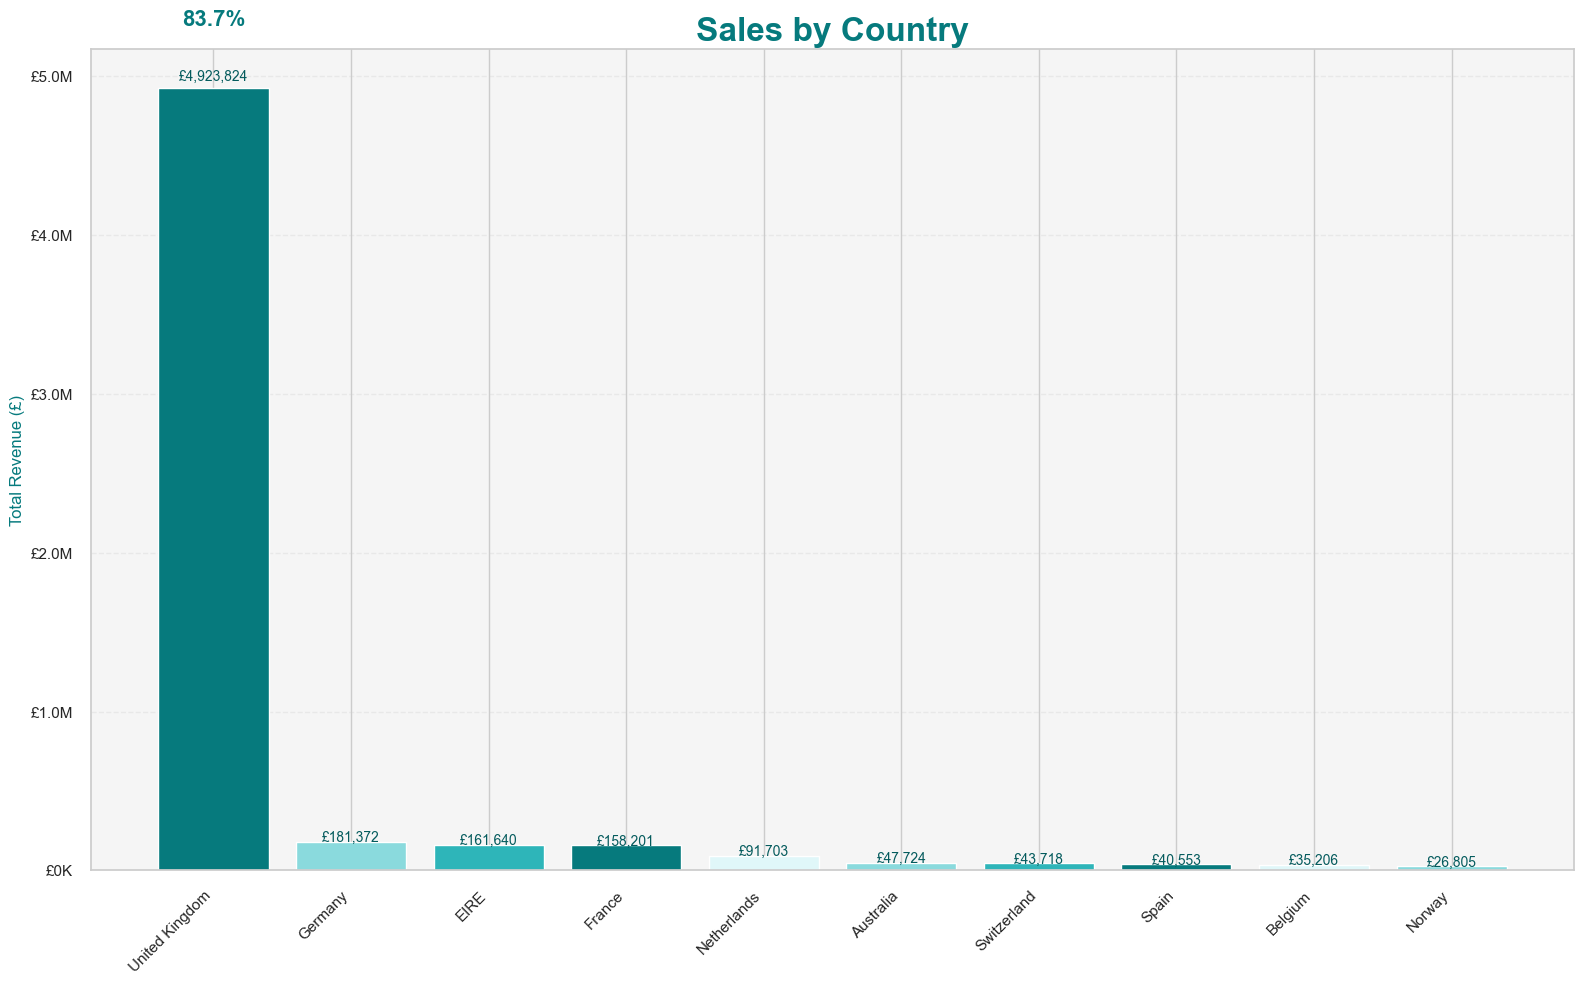

In [52]:
country = (
    df.groupby('Country')
      .agg(
          TotalRevenue=('TotalAmount', 'sum'),
          TransactionCount=('TotalAmount', 'count'),
          TotalQuantity=('Quantity', 'sum'),
          UniqueInvoices=('InvoiceNo', 'nunique')
      )
      .sort_values('TotalRevenue', ascending=False)
)

country['RevenuePercentage'] = (
    country['TotalRevenue'] / country['TotalRevenue'].sum() * 100
).round(2)

top = country.head(10)

plt.figure(figsize=(16, 10))
ax = plt.gca()
ax.set_facecolor('#f5f5f5')

bars = ax.bar(
    top.index,
    top['TotalRevenue'],
    color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top))],
    edgecolor='white'
)

plt.title("Sales by Country", fontsize=24, fontweight='bold', color='#067A7D')
plt.ylabel("Total Revenue (£)", color='#067A7D')
plt.xticks(rotation=45, ha='right')

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'£{x/1e6:.1f}M' if x >= 1e6 else f'£{x/1e3:.0f}K')
)

plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.01,
        f"£{height:,.0f}",
        ha='center',
        fontsize=10,
        color='#045B5D'
    )

top_revenue = top.iloc[0]['TotalRevenue']
top_percentage = top.iloc[0]['RevenuePercentage']

ax.text(
    0,
    top_revenue + top_revenue * 0.08,
    f"{top_percentage:.1f}%",
    ha='center',
    fontsize=16,
    fontweight='bold',
    color='#067A7D'
)

plt.tight_layout()
plt.show()

**REVENUE BY COUNTRY (EXC. UK)**

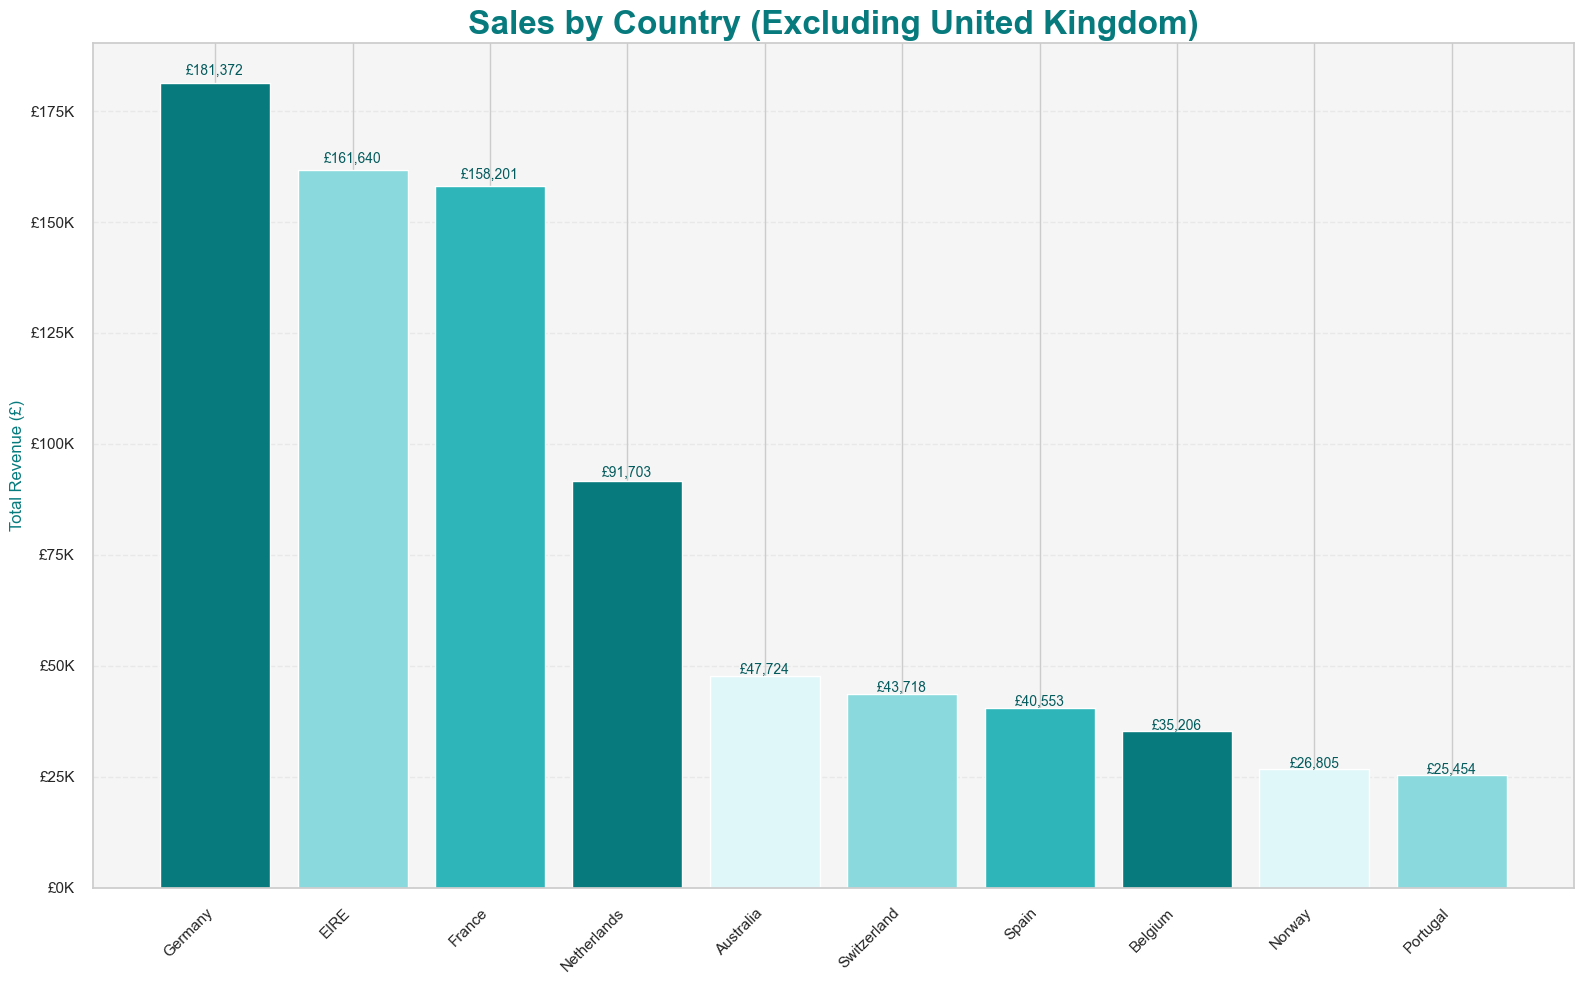

In [53]:
# Menghapus United Kingdom untuk analisis yang lebih seimbang
df_filtered = df[df['Country'] != 'United Kingdom']

df_filtered['TotalAmount'] = df_filtered['Quantity'] * df_filtered['UnitPrice']

country = (
    df_filtered.groupby('Country')
        .agg(
            TotalRevenue=('TotalAmount', 'sum'),
            TransactionCount=('TotalAmount', 'count'),
            TotalQuantity=('Quantity', 'sum'),
            UniqueInvoices=('InvoiceNo', 'nunique')
        )
        .sort_values('TotalRevenue', ascending=False)
)

country['RevenuePercentage'] = (
    country['TotalRevenue'] / country['TotalRevenue'].sum() * 100
).round(2)

top = country.head(10)

plt.figure(figsize=(16, 10))
ax = plt.gca()
ax.set_facecolor('#f5f5f5')

bars = ax.bar(
    top.index,
    top['TotalRevenue'],
    color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top))],
    edgecolor='white'
)

plt.title(
    "Sales by Country (Excluding United Kingdom)",
    fontsize=24,
    fontweight='bold',
    color='#067A7D'
)

plt.ylabel("Total Revenue (£)", color='#067A7D')
plt.xticks(rotation=45, ha='right')

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'£{x/1e6:.1f}M' if x >= 1e6 else f'£{x/1e3:.0f}K')
)

plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.01,
        f"£{height:,.0f}",
        ha='center',
        fontsize=10,
        color='#045B5D'
    )

plt.tight_layout()
plt.show()


**TOP SELLING PRODUCTS**

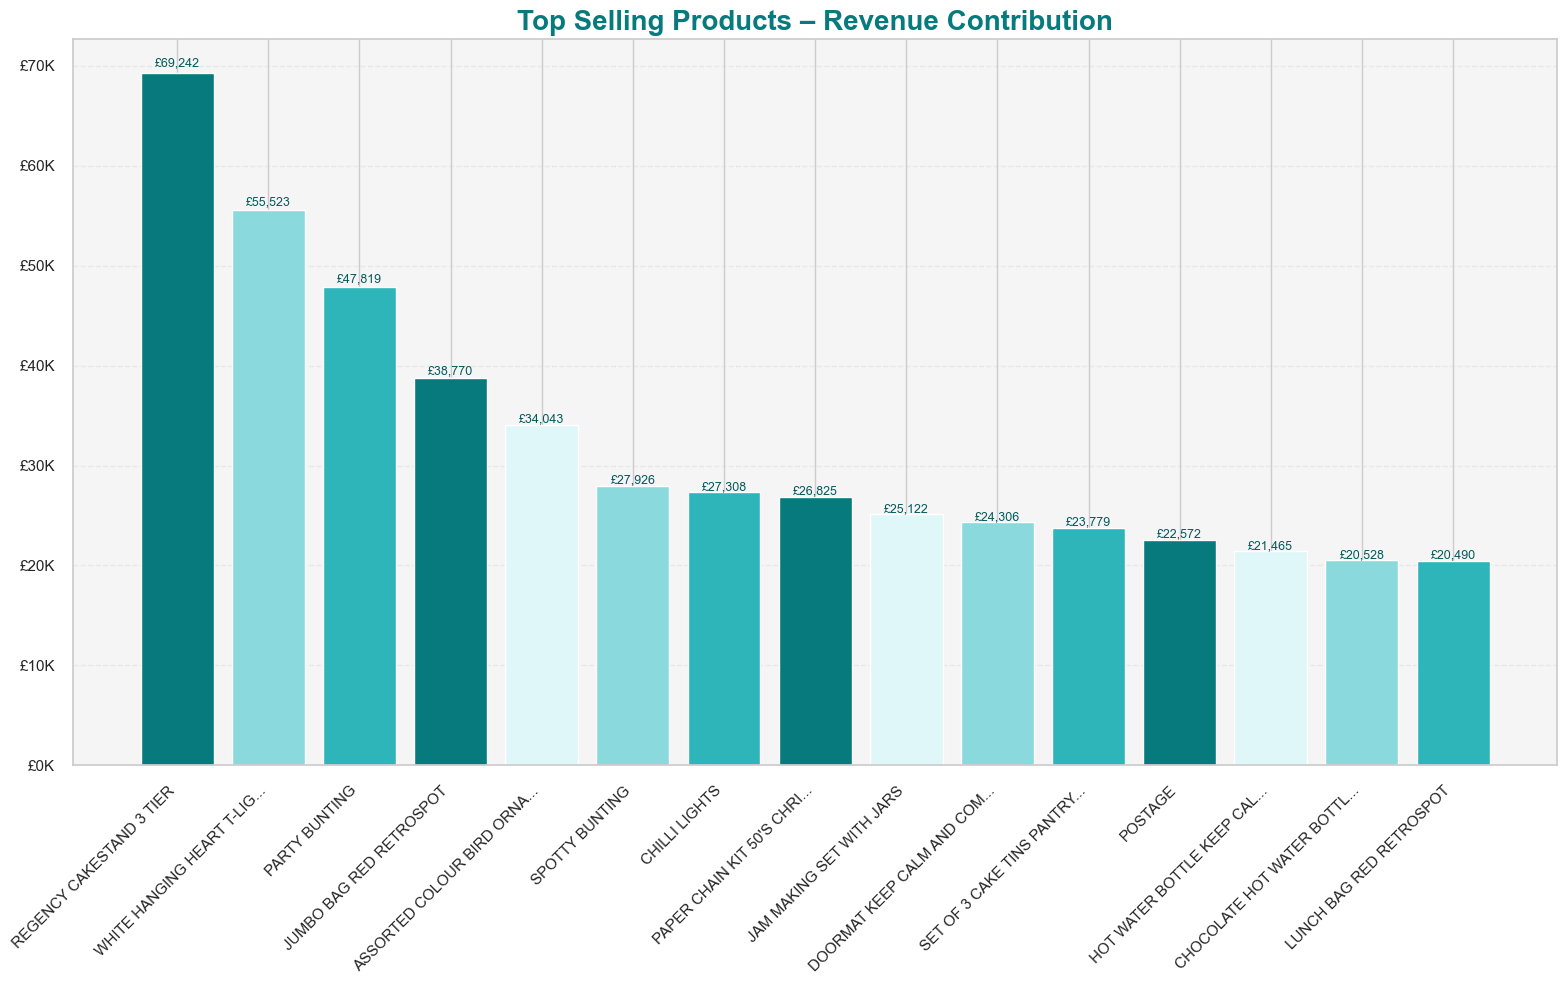

In [54]:
product = (
    df.groupby('Description')
      .agg(
          TotalRevenue=('TotalAmount', 'sum'),
          TotalQuantity=('Quantity', 'sum'),
          UniqueInvoices=('InvoiceNo', 'nunique'),
          AvgPrice=('UnitPrice', 'mean')
      )
      .sort_values('TotalRevenue', ascending=False)
)

top = product.head(15)

plt.figure(figsize=(16, 10))
ax = plt.gca()
ax.set_facecolor('#f5f5f5')

bars = ax.bar(
    range(len(top)),
    top['TotalRevenue'],
    color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top))],
    edgecolor='white'
)

plt.title(
    "Top Selling Products – Revenue Contribution",
    fontsize=20,
    fontweight='bold',
    color='#067A7D'
)

names = [n[:25] + "..." if len(n) > 25 else n for n in top.index]
plt.xticks(range(len(top)), names, rotation=45, ha='right')

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'£{x/1000:.0f}K')
)

plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.01,
        f"£{height:,.0f}",
        ha='center',
        fontsize=9,
        color='#045B5D'
    )

plt.tight_layout()
plt.show()


**FEATURE ENGINEERING**

In [55]:
df = df[df['InvoiceNo'].astype(str).str[0] != 'C']
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df.drop_duplicates(inplace=True)

df['Total_transaction'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDate_only'] = df['InvoiceDate'].dt.date


In [56]:
monthly = (
    df.groupby('InvoiceYearMonth')
      .agg(
          Total_transaction=('Total_transaction', 'sum'),
          Orders=('InvoiceNo', 'nunique'),
          Active_Customers=('CustomerID', 'nunique')
      )
      .reset_index()
)

monthly['AOV'] = monthly['Total_transaction'] / monthly['Orders']

monthly['InvoiceYearMonth'] = monthly['InvoiceYearMonth'].astype(str)
monthly

InvoiceYearMonth  Total_transaction  Orders  Active_Customers    AOV
0           2010-12          398711.02    1400               885 284.79
1           2011-01          331374.53     987               741 335.74
2           2011-02          313458.13     997               758 314.40
3           2011-03          409907.00    1321               974 310.30
4           2011-04          330209.62    1149               856 287.39
5           2011-05          469513.72    1555              1056 301.94
6           2011-06          414125.12    1393               991 297.29
7           2011-07          408760.65    1331               949 307.11
8           2011-08          428471.53    1280               935 334.74
9           2011-09          648901.85    1755              1266 369.74
10          2011-10          702589.90    1929              1364 364.22
11          2011-11          859659.10    2657              1664 323.55
12          2011-12          239674.52     778               615 308.06

**MONTHLY TOTAL TRANSACTION TREND**

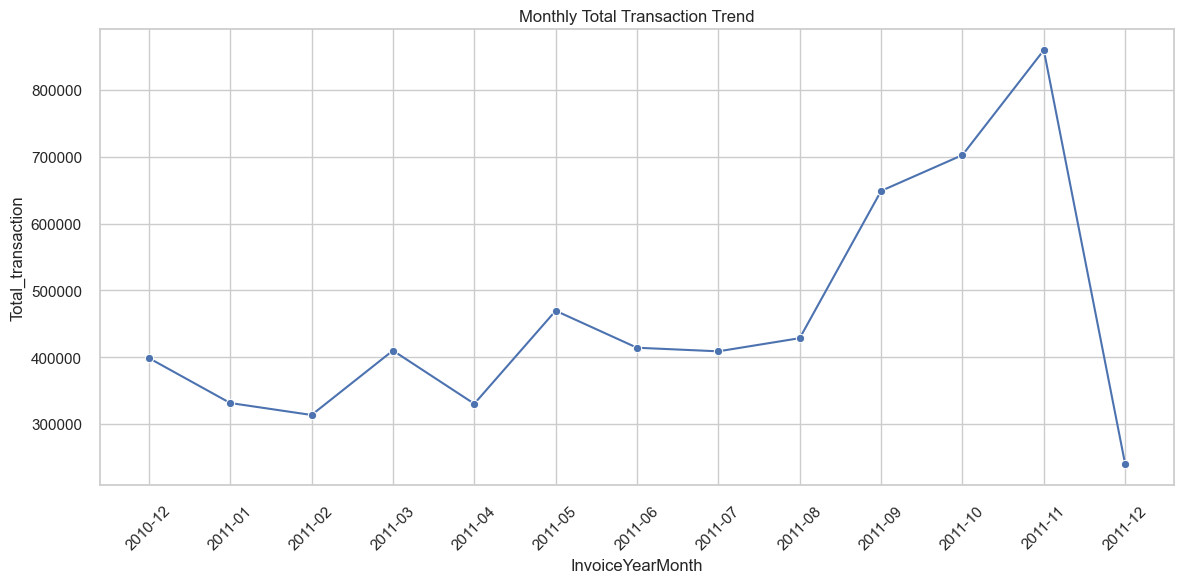

In [57]:
# Visualisasi tren transaksi bulanan
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly,
    x='InvoiceYearMonth',
    y='Total_transaction',
    marker='o'
)

plt.title("Monthly Total Transaction Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**TOP 10 PRODUCTS BY TOTAL TRANSACTION**

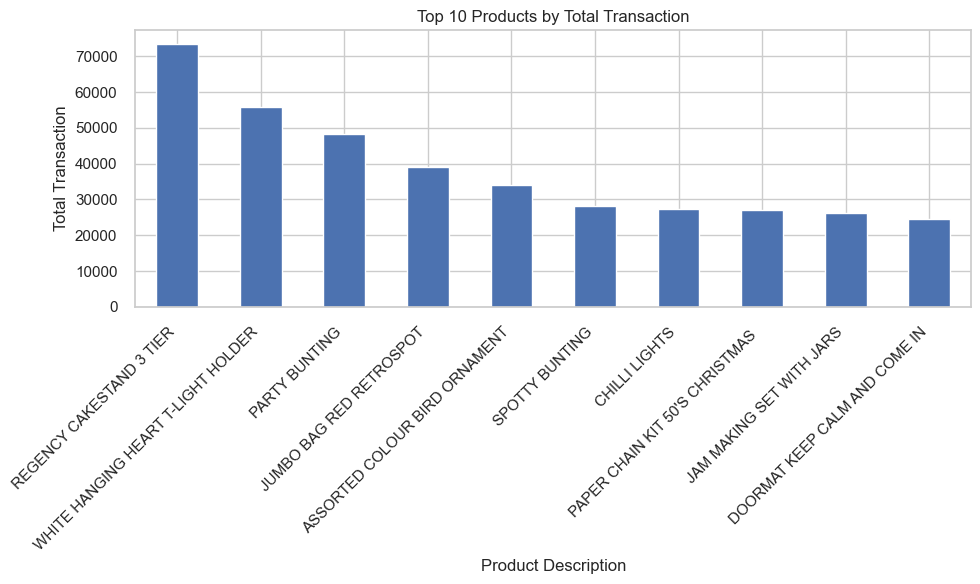

In [58]:
# Produk dengan total transaksi tertinggi
top_products = (
    df.groupby('Description')['Total_transaction']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top_products.plot(kind='bar', figsize=(10, 6))
plt.title("Top 10 Products by Total Transaction")
plt.xlabel("Product Description")
plt.ylabel("Total Transaction")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**TOP 10 COUNTRIES BY TOTAL TRANSACTION**

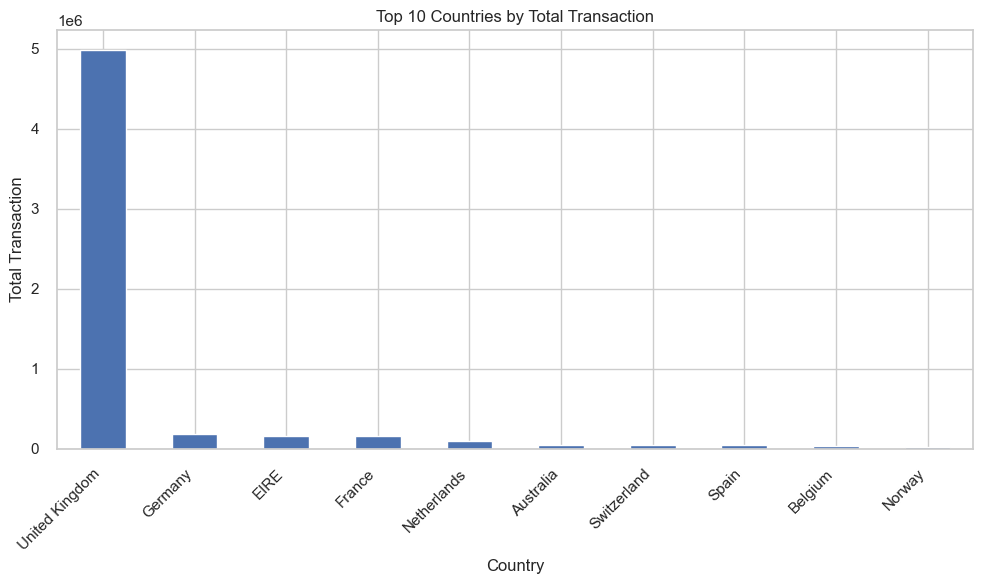

In [59]:
# Negara dengan total transaksi tertinggi
top_countries = (
    df.groupby('Country')['Total_transaction']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top_countries.plot(kind='bar', figsize=(10, 6))
plt.title("Top 10 Countries by Total Transaction")
plt.xlabel("Country")
plt.ylabel("Total Transaction")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [60]:
# Final check
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER      6.00   
1    536365     71053                  WHITE METAL LANTERN      6.00   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER      8.00   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE      6.00   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.      6.00   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  \
0 2010-12-01 08:26:00       2.55    17850.00  United Kingdom        15.30   
1 2010-12-01 08:26:00       3.39    17850.00  United Kingdom        20.34   
2 2010-12-01 08:26:00       2.75    17850.00  United Kingdom        22.00   
3 2010-12-01 08:26:00       3.39    17850.00  United Kingdom        20.34   
4 2010-12-01 08:26:00       3.39    17850.00  United Kingdom        20.34   

   Total_transaction InvoiceYearMonth InvoiceDate_only  
0              15.30          2010-12       2010-12-01  
1              20.34          2010-12       2010-12-01  
2              22.00          2010-12       2010-12-01  
3              20.34          2010-12       2010-12-01  
4              20.34          2010-12       2010-12-01

## **RFM Analysis**

In [61]:
# Menentukan tanggal referensi (1 hari setelah transaksi terakhir)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby('CustomerID')
      .agg(
          Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
          Frequency=('InvoiceNo', 'count'),
          Monetary=('Total_transaction', 'sum')
      )
)

rfm.head()

Recency  Frequency  Monetary
CustomerID                              
12346.00        326          1     28.08
12347.00          2        182   3877.44
12348.00         75         31    557.57
12349.00         19         73   1336.65
12350.00        310         17    301.90

In [62]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


In [63]:
# R_Score: semakin kecil recency, semakin tinggi skor
rfm['R_Score'] = pd.qcut(
    rfm['Recency'].rank(method='first'),
    5,
    labels=[5, 4, 3, 2, 1]
)

# F_Score: semakin tinggi frekuensi, semakin tinggi skor
rfm['F_Score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1, 2, 3, 4, 5]
)

# M_Score: semakin besar nilai transaksi, semakin tinggi skor
rfm['M_Score'] = pd.qcut(
    rfm['Monetary'].rank(method='first'),
    5,
    labels=[1, 2, 3, 4, 5]
)

rfm['RFM_Code'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm['RFM_Score'] = (
    rfm[['R_Score', 'F_Score', 'M_Score']]
    .astype(int)
    .sum(axis=1)
)

rfm.sort_values('RFM_Score', ascending=False).head(10)


Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Code  \
CustomerID                                                                  
18283.00          4        721   2032.63       5       5       5      555   
18245.00          7        175   2495.27       5       5       5      555   
18229.00         12        164   5958.05       5       5       5      555   
18225.00          3        269   5088.04       5       5       5      555   
18223.00          5        272   6125.39       5       5       5      555   
18210.00          2        134   2480.96       5       5       5      555   
18198.00          4        159   3203.38       5       5       5      555   
18145.00         13        221   2811.58       5       5       5      555   
18122.00          8        357   1723.44       5       5       5      555   
18118.00         11       1263   5266.51       5       5       5      555   

            RFM_Score  
CustomerID             
18283.00           15  
18245.00           15  
18229.00           15  
18225.00           15  
18223.00           15  
18210.00           15  
18198.00           15  
18145.00           15  
18122.00           15  
18118.00           15

**MEMBUAT LABEL SEGMENT RFM**

In [64]:
def label_rfm(row):
    r = int(row["R_Score"])
    f = int(row["F_Score"])
    m = int(row["M_Score"])

    # Champions
    if r == 5 and f in [4, 5] and m in [4, 5]:
        return "Champions"

    # Can't Lose Them
    if r in [1, 2] and f == 5 and m == 5:
        return "Can't Lose Them"

    # Loyal Customers
    if r in [3, 4] and f in [4, 5] and m in [4, 5]:
        return "Loyal Customers"

    # Potential Loyalist
    if r in [4, 5] and f in [2, 3] and m in [2, 3]:
        return "Potential Loyalist"

    # New Customers
    if r == 5 and f == 1 and m == 1:
        return "New Customers"

    # Promising
    if r == 4 and f == 1 and m == 1:
        return "Promising"

    # Needs Attention
    if r == 3 and f == 3 and m == 3:
        return "Needs Attention"

    # About To Sleep
    if r == 3 and f in [1, 2] and m in [1, 2]:
        return "About To Sleep"

    # At Risk
    if r in [1, 2] and f in [3, 4] and m in [3, 4]:
        return "At Risk"

    # Hibernating
    if r in [1, 2] and f in [1, 2] and m in [1, 2]:
        return "Hibernating"


    # 11. Regular Customers (zona transisi)
    if r == 3:
        return "Regular Customers"



# Apply to RFM dataframe
rfm["RFM_Segment"] = rfm.apply(label_rfm, axis=1)

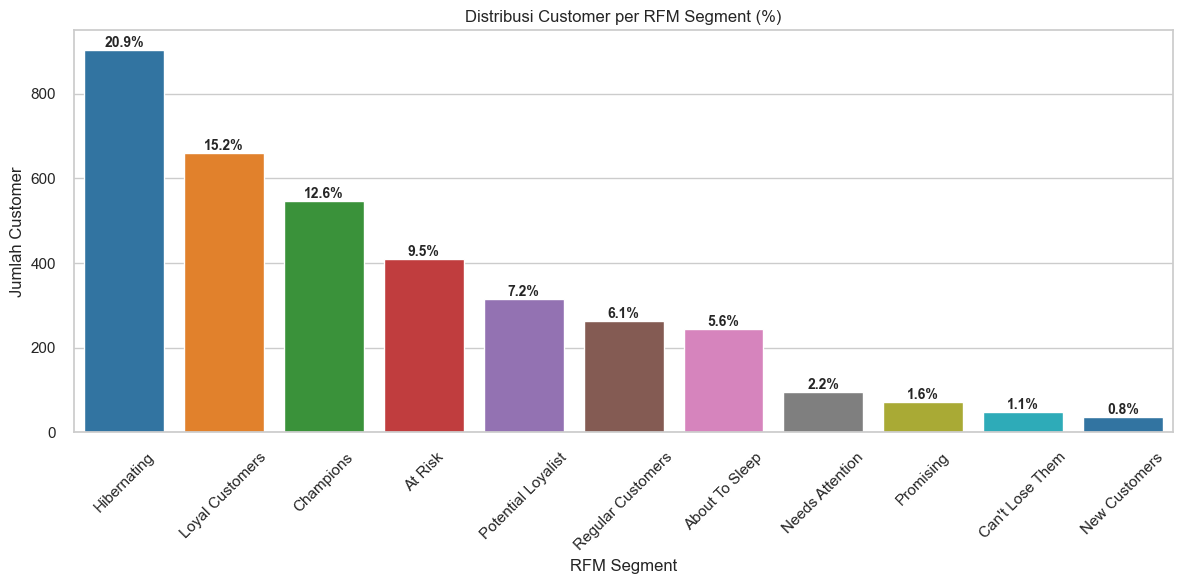

In [65]:
# Visualisasi distribusi customer berdasarkan RFM Segment
plt.figure(figsize=(12, 6))

segment_counts = rfm['RFM_Segment'].value_counts()
segment_order = segment_counts.index
total_customers = len(rfm)

ax = sns.countplot(
    data=rfm,
    x='RFM_Segment',
    order=segment_order,
    palette='tab10'
)

for bar in ax.patches:
    count = bar.get_height()
    percentage = 100 * count / total_customers
    ax.annotate(
        f'{percentage:.1f}%',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.xticks(rotation=45)
plt.title("Distribusi Customer per RFM Segment (%)")
plt.xlabel("RFM Segment")
plt.ylabel("Jumlah Customer")
plt.tight_layout()
plt.show()

## **Feature Selection**

In [66]:
df = df.merge(
    rfm[
        [
            'Recency',
            'Frequency',
            'Monetary',
            'R_Score',
            'F_Score',
            'M_Score',
            'RFM_Segment',
            'RFM_Score'
        ]
    ],
    on='CustomerID',
    how='left'
)

df.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER      6.00   
1    536365     71053                  WHITE METAL LANTERN      6.00   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER      8.00   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE      6.00   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.      6.00   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  \
0 2010-12-01 08:26:00       2.55    17850.00  United Kingdom        15.30   
1 2010-12-01 08:26:00       3.39    17850.00  United Kingdom        20.34   
2 2010-12-01 08:26:00       2.75    17850.00  United Kingdom        22.00   
3 2010-12-01 08:26:00       3.39    17850.00  United Kingdom        20.34   
4 2010-12-01 08:26:00       3.39    17850.00  United Kingdom        20.34   

   Total_transaction InvoiceYearMonth InvoiceDate_only  Recency  Frequency  \
0              15.30          2010-12       2010-12-01      372        297   
1              20.34          2010-12       2010-12-01      372        297   
2              22.00          2010-12       2010-12-01      372        297   
3              20.34          2010-12       2010-12-01      372        297   
4              20.34          2010-12       2010-12-01      372        297   

   Monetary R_Score F_Score M_Score      RFM_Segment  RFM_Score  
0   4904.66       1       5       5  Can't Lose Them         11  
1   4904.66       1       5       5  Can't Lose Them         11  
2   4904.66       1       5       5  Can't Lose Them         11  
3   4904.66       1       5       5  Can't Lose Them         11  
4   4904.66       1       5       5  Can't Lose Them         11

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392662 entries, 0 to 392661
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392662 non-null  object        
 1   StockCode          392662 non-null  object        
 2   Description        392662 non-null  object        
 3   Quantity           392662 non-null  float64       
 4   InvoiceDate        392662 non-null  datetime64[ns]
 5   UnitPrice          392662 non-null  float64       
 6   CustomerID         392662 non-null  float64       
 7   Country            392662 non-null  object        
 8   TotalAmount        392662 non-null  float64       
 9   Total_transaction  392662 non-null  float64       
 10  InvoiceYearMonth   392662 non-null  period[M]     
 11  InvoiceDate_only   392662 non-null  object        
 12  Recency            392662 non-null  int64         
 13  Frequency          392662 non-null  int64   

In [68]:
df['InvoiceYearMonth'] = (
    df['InvoiceDate']
    .dt.to_period('M')
    .astype(str)
)

df['InvoiceYearMonth_num'] = (
    df['InvoiceYearMonth']
    .str.replace("-", "")
    .astype(int)
)

In [69]:
other_features = (
    df.groupby('CustomerID')
      .agg(
          Quantity_total=('Quantity', 'sum'),
          UnitPrice_avg=('UnitPrice', 'mean')
      )
)

other_features.head()

rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

In [70]:
pd.DataFrame(rfm_features).skew()

Recency      1.25
Frequency   18.04
Monetary    15.39
dtype: float64

In [71]:
pt = PowerTransformer(method='yeo-johnson')
rfm_power = pt.fit_transform(rfm_features)

scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_power)

In [72]:
rfm_scaled = pd.DataFrame(
    rfm_normalized,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'],
    index=rfm.index
)

rfm_scaled.head()

Recency_scaled  Frequency_scaled  Monetary_scaled
CustomerID                                                   
12346.00              1.62             -2.43            -2.46
12347.00             -1.82              1.19             1.49
12348.00              0.30             -0.21            -0.04
12349.00             -0.69              0.46             0.65
12350.00              1.57             -0.67            -0.54

In [73]:
rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

In [74]:
X_final_full = pd.concat(
    [
        rfm_scaled,
        other_features
    ],
    axis=1
)

X_final_full = X_final_full.dropna()

X_final_full.head()

Recency_scaled  Frequency_scaled  Monetary_scaled  Quantity_total  \
CustomerID                                                                      
12346.00              1.62             -2.43            -2.46           27.00   
12347.00             -1.82              1.19             1.49         2167.00   
12348.00              0.30             -0.21            -0.04          716.00   
12349.00             -0.69              0.46             0.65          613.00   
12350.00              1.57             -0.67            -0.54          197.00   

            UnitPrice_avg  
CustomerID                 
12346.00             1.04  
12347.00             2.50  
12348.00             1.57  
12349.00             3.44  
12350.00             1.93

In [75]:
X_final_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Recency_scaled    4338 non-null   float64
 1   Frequency_scaled  4338 non-null   float64
 2   Monetary_scaled   4338 non-null   float64
 3   Quantity_total    4338 non-null   float64
 4   UnitPrice_avg     4338 non-null   float64
dtypes: float64(5)
memory usage: 203.3 KB


## **Eksperimen 1: Algoritma K Means & K = 4**

Fitur numerik yang dipakai:             Recency_scaled  Frequency_scaled  Monetary_scaled  Quantity_total  \
CustomerID                                                                      
12346.00              1.62             -2.43            -2.46           27.00   
12347.00             -1.82              1.19             1.49         2167.00   
12348.00              0.30             -0.21            -0.04          716.00   
12349.00             -0.69              0.46             0.65          613.00   
12350.00              1.57             -0.67            -0.54          197.00   
...                    ...               ...              ...             ...   
18280.00              1.46             -1.07            -0.98           45.00   
18281.00              1.06             -1.32            -1.82           54.00   
18282.00             -1.20             -0.94            -1.09           82.00   
18283.00             -1.54              2.30             0.98         1357.00   


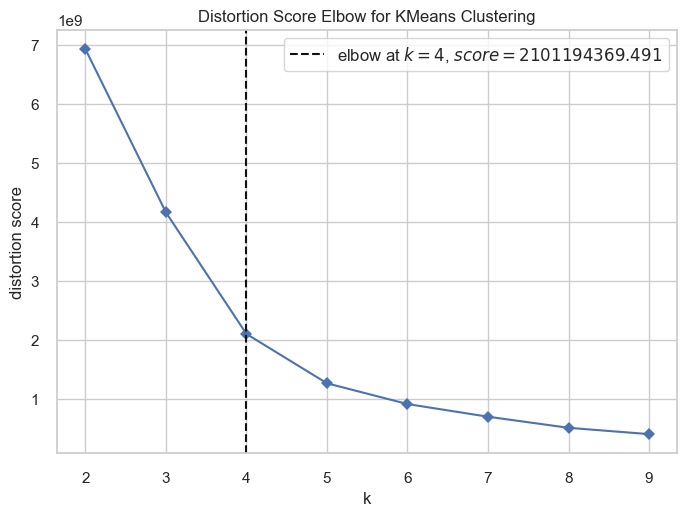

Rekomendasi jumlah cluster (Elbow): 4


In [76]:
X = X_final_full.copy()

print("Fitur numerik yang dipakai:", X_final_full)
print("Shape:", X.shape)

model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(
    model,
    k=(2, 10),
    metric='distortion',
    timings=False
)

visualizer.fit(X)
visualizer.show()

best_k = visualizer.elbow_value_
print("Rekomendasi jumlah cluster (Elbow):", best_k)

In [77]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    batch_size=200,
    init="k-means++",
    n_init=55,
    max_iter=600,
    reassignment_ratio=0.0012,
    random_state=42
)



clusters = kmeans.fit_predict(X)

## **Evaluation**

In [78]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    silhouette_samples
)


pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

labels = kmeans.labels_

silhouette_pca = silhouette_score(
    X_pca,
    labels,
    sample_size=1000,
    random_state=42
)

silhouette_original = silhouette_score(
    X,
    labels,
    sample_size=1000,
    random_state=42
)

calinski = calinski_harabasz_score(X, labels)

# ================= Output =================
print("Clustering Metrics")
print(f"Silhouette Score (PCA 3D, sampled) : {silhouette_pca:.4f}")
print(f"Silhouette Score (Original, samp.) : {silhouette_original:.4f}")
print(f"Calinski-Harabasz Score            : {calinski:.4f}")

Clustering Metrics
Silhouette Score (PCA 3D, sampled) : 0.7060
Silhouette Score (Original, samp.) : 0.7060
Calinski-Harabasz Score            : 5050.0044


In [79]:
def silhouette_by_cluster(X_scaled, labels):
    sil_samples = silhouette_samples(X_scaled, labels)
    unique_clusters = np.unique(labels)

    print("Silhouette Score per Cluster")
    for c in unique_clusters:
        cluster_score = sil_samples[labels == c].mean()
        print(f"Cluster {c}: {cluster_score:.4f}")


silhouette_by_cluster(X, labels)

Silhouette Score per Cluster
Cluster 0: 0.4895
Cluster 1: 0.2621
Cluster 2: 0.7794
Cluster 3: 0.4168


## **Interpretation**

In [80]:
cluster_result = pd.DataFrame({
    'CustomerID': X_final_full.index,
    'Cluster': clusters
})

cluster_result.head()

CustomerID  Cluster
0    12346.00        2
1    12347.00        0
2    12348.00        2
3    12349.00        2
4    12350.00        2

In [81]:
final_df = pd.concat(
    [
        cluster_result.set_index('CustomerID'),
        X_final_full
    ],
    axis=1
)

final_df.head()

Cluster  Recency_scaled  Frequency_scaled  Monetary_scaled  \
CustomerID                                                               
12346.00          2            1.62             -2.43            -2.46   
12347.00          0           -1.82              1.19             1.49   
12348.00          2            0.30             -0.21            -0.04   
12349.00          2           -0.69              0.46             0.65   
12350.00          2            1.57             -0.67            -0.54   

            Quantity_total  UnitPrice_avg  
CustomerID                                 
12346.00             27.00           1.04  
12347.00           2167.00           2.50  
12348.00            716.00           1.57  
12349.00            613.00           3.44  
12350.00            197.00           1.93

In [82]:
cluster_profile = final_df.groupby('Cluster').mean().round(2)
cluster_profile

Recency_scaled  Frequency_scaled  Monetary_scaled  Quantity_total  \
Cluster                                                                      
0                 -0.67              1.08             1.17         1625.59   
1                 -1.53              3.13             3.30        25575.62   
2                  0.21             -0.33            -0.36          300.13   
3                 -1.19              1.78             2.04         4745.76   

         UnitPrice_avg  
Cluster                 
0                 2.53  
1                 2.38  
2                 2.85  
3                 2.48

In [83]:
cols = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']

X_original_part = scaler.inverse_transform(final_df[cols])

final_df[['Recency', 'Frequency', 'Monetary']] = X_original_part

cluster_profile = final_df.groupby('Cluster').mean().round(2)
cluster_profile

Recency_scaled  Frequency_scaled  Monetary_scaled  Quantity_total  \
Cluster                                                                      
0                 -0.67              1.08             1.17         1625.59   
1                 -1.53              3.13             3.30        25575.62   
2                  0.21             -0.33            -0.36          300.13   
3                 -1.19              1.78             2.04         4745.76   

         UnitPrice_avg  Recency  Frequency  Monetary  
Cluster                                               
0                 2.53    -0.67       1.08      1.17  
1                 2.38    -1.53       3.13      3.30  
2                 2.85     0.21      -0.33     -0.36  
3                 2.48    -1.19       1.78      2.04

In [84]:
rfm_clean = rfm[
    [
        'Recency',
        'Frequency',
        'Monetary',
        'R_Score',
        'F_Score',
        'M_Score'
    ]
]

rfm_clean = rfm_clean.drop(
    columns=['Recency', 'Frequency', 'Monetary'],
    errors='ignore'
)

final_merged = final_df.join(rfm_clean, how='left')

final_merged.head()

Cluster  Recency_scaled  Frequency_scaled  Monetary_scaled  \
CustomerID                                                               
12346.00          2            1.62             -2.43            -2.46   
12347.00          0           -1.82              1.19             1.49   
12348.00          2            0.30             -0.21            -0.04   
12349.00          2           -0.69              0.46             0.65   
12350.00          2            1.57             -0.67            -0.54   

            Quantity_total  UnitPrice_avg  Recency  Frequency  Monetary  \
CustomerID                                                                
12346.00             27.00           1.04     1.62      -2.43     -2.46   
12347.00           2167.00           2.50    -1.82       1.19      1.49   
12348.00            716.00           1.57     0.30      -0.21     -0.04   
12349.00            613.00           3.44    -0.69       0.46      0.65   
12350.00            197.00           1.93     1.57      -0.67     -0.54   

            R_Score  F_Score  M_Score  
CustomerID                             
12346.00          1        1        1  
12347.00          5        5        5  
12348.00          2        3        3  
12349.00          4        4        4  
12350.00          1        2        2

In [85]:
# Daftar skor RFM
scores = ['R_Score', 'F_Score', 'M_Score']

# Menghitung distribusi skor RFM per cluster
cluster_score_counts = (
    final_merged
    .groupby('Cluster')[scores]
    .apply(
        lambda df: df.apply(
            lambda col: col.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
        )
    )
)

cluster_score_counts

R_Score  F_Score  M_Score
Cluster                             
0       1       14        0        0
        2       78        0        0
        3      155       10        2
        4      209      265      139
        5      307      488      622
1       1        0        0        0
        2        0        0        0
        3        0        0        0
        4        1        0        0
        5       12       13       13
2       1      854      868      868
        2      788      867      867
        3      702      858      866
        4      616      602      728
        5      455      220       86
3       1        0        0        0
        2        1        0        0
        3       11        0        0
        4       41        0        0
        5       94      147      147

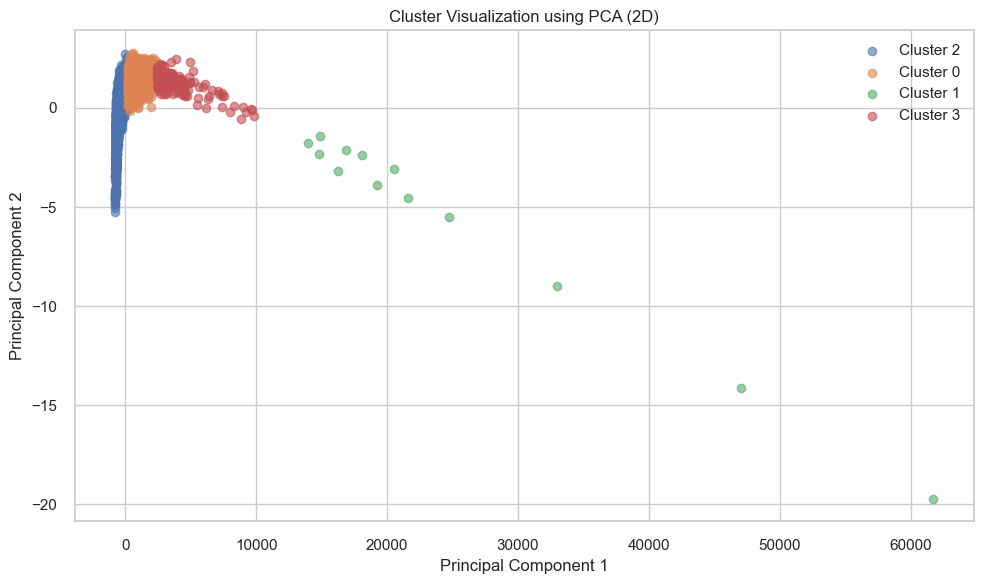

In [86]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_final_full)

final_df['PC1'] = pca_result[:, 0]
final_df['PC2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
for c in final_df['Cluster'].unique():
    plt.scatter(
        final_df[final_df['Cluster'] == c]['PC1'],
        final_df[final_df['Cluster'] == c]['PC2'],
        label=f'Cluster {c}',
        alpha=0.6
    )

plt.legend()
plt.title("Cluster Visualization using PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


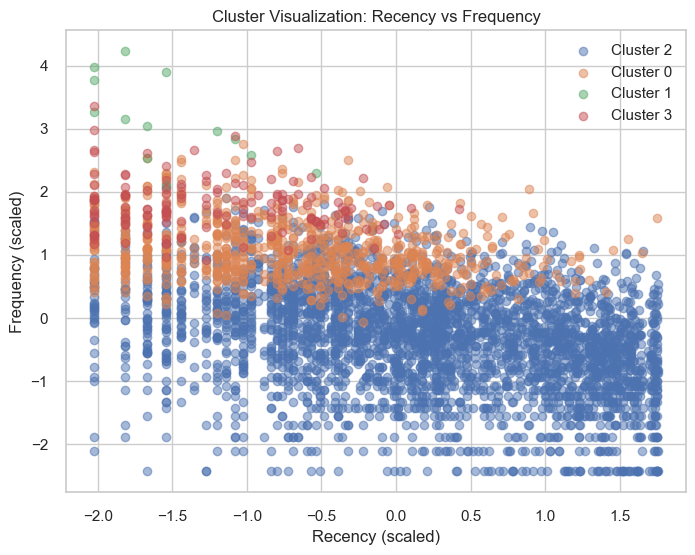

In [87]:
plt.figure(figsize=(8, 6))

for c in final_df['Cluster'].unique():
    subset = final_df[final_df['Cluster'] == c]
    plt.scatter(
        subset['Recency_scaled'],
        subset['Frequency_scaled'],
        alpha=0.5,
        label=f'Cluster {c}'
    )

plt.xlabel('Recency (scaled)')
plt.ylabel('Frequency (scaled)')
plt.title('Cluster Visualization: Recency vs Frequency')
plt.legend()
plt.show()

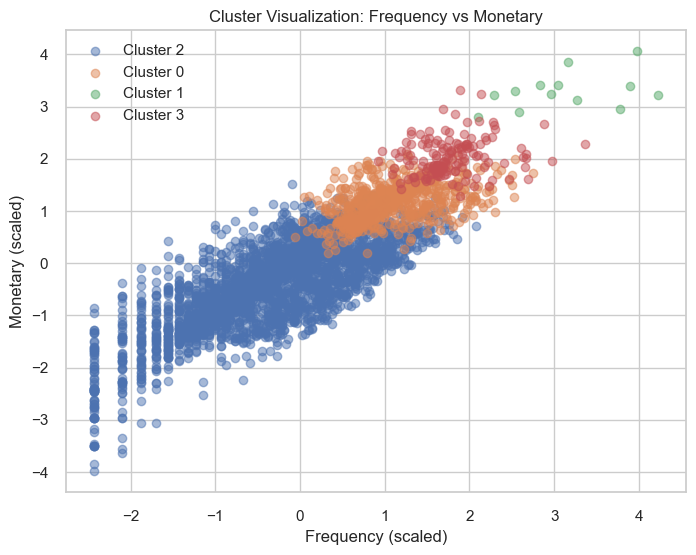

In [88]:
plt.figure(figsize=(8, 6))

for c in final_df['Cluster'].unique():
    subset = final_df[final_df['Cluster'] == c]
    plt.scatter(
        subset['Frequency_scaled'],
        subset['Monetary_scaled'],
        alpha=0.5,
        label=f'Cluster {c}'
    )

plt.xlabel('Frequency (scaled)')
plt.ylabel('Monetary (scaled)')
plt.title('Cluster Visualization: Frequency vs Monetary')
plt.legend()
plt.show()

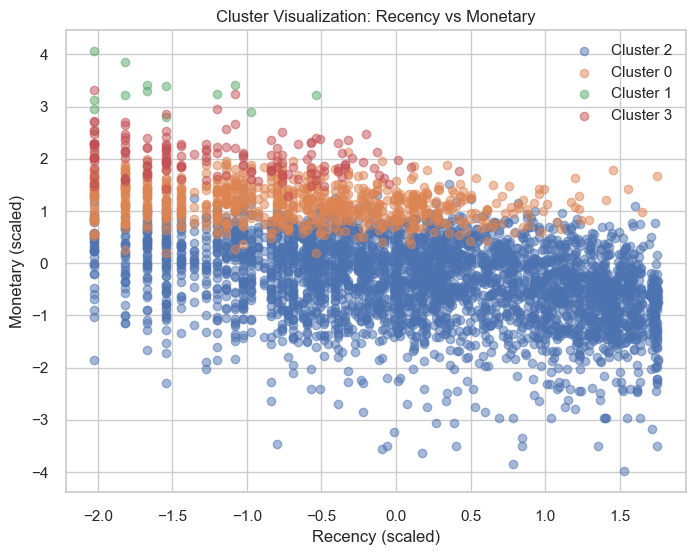

In [89]:
plt.figure(figsize=(8, 6))

for c in final_df['Cluster'].unique():
    subset = final_df[final_df['Cluster'] == c]
    plt.scatter(
        subset['Recency_scaled'],
        subset['Monetary_scaled'],
        alpha=0.5,
        label=f'Cluster {c}'
    )

plt.xlabel('Recency (scaled)')
plt.ylabel('Monetary (scaled)')
plt.title('Cluster Visualization: Recency vs Monetary')
plt.legend()
plt.show()

In [90]:
rfm_profile = (
    final_df
    .groupby('Cluster')[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]
    .mean()
    .round(2)
)

rfm_profile

Recency_scaled  Frequency_scaled  Monetary_scaled
Cluster                                                   
0                 -0.67              1.08             1.17
1                 -1.53              3.13             3.30
2                  0.21             -0.33            -0.36
3                 -1.19              1.78             2.04

In [91]:
df_customer_trans = (
    df.groupby('CustomerID')
      .agg(
          Quantity_total=('Quantity', 'sum'),
          UnitPrice_avg=('UnitPrice', 'mean'),
          TotalAmount_total=('TotalAmount', 'sum'),
          Total_transaction_total=('Total_transaction', 'sum'),
          InvoiceYearMonth_num=('InvoiceYearMonth_num', 'max')
      )
)

df_customer = (
    df_customer_trans
    .join(
        rfm[
            [
                'Recency',
                'Frequency',
                'Monetary',
                'R_Score',
                'F_Score',
                'M_Score',
                'RFM_Score',
                'RFM_Segment'
            ]
        ],
        how='left'
    )
    .reset_index()
)

final_customer_df = (
    df_customer
    .merge(
        cluster_result,
        on='CustomerID',
        how='left'
    )
    [
        [
            'CustomerID',
            'Recency',
            'Frequency',
            'Monetary',
            'Quantity_total',
            'UnitPrice_avg',
            'TotalAmount_total',
            'Total_transaction_total',
            'InvoiceYearMonth_num',
            'R_Score',
            'F_Score',
            'M_Score',
            'RFM_Score',
            'RFM_Segment',
            'Cluster'
        ]
    ]
)

final_customer_df.head()


CustomerID  Recency  Frequency  Monetary  Quantity_total  UnitPrice_avg  \
0    12346.00      326          1     28.08           27.00           1.04   
1    12347.00        2        182   3877.44         2167.00           2.50   
2    12348.00       75         31    557.57          716.00           1.57   
3    12349.00       19         73   1336.65          613.00           3.44   
4    12350.00      310         17    301.90          197.00           1.93   

   TotalAmount_total  Total_transaction_total  InvoiceYearMonth_num  R_Score  \
0              28.08                    28.08                201101        1   
1            3877.44                  3877.44                201112        5   
2             557.57                   557.57                201109        2   
3            1336.65                  1336.65                201111        4   
4             301.90                   301.90                201102        1   

   F_Score  M_Score  RFM_Score      RFM_Segment  Cluster  
0        1        1          3      Hibernating        2  
1        5        5         15        Champions        0  
2        3        3          8          At Risk        2  
3        4        4         12  Loyal Customers        2  
4        2        2          5      Hibernating        2

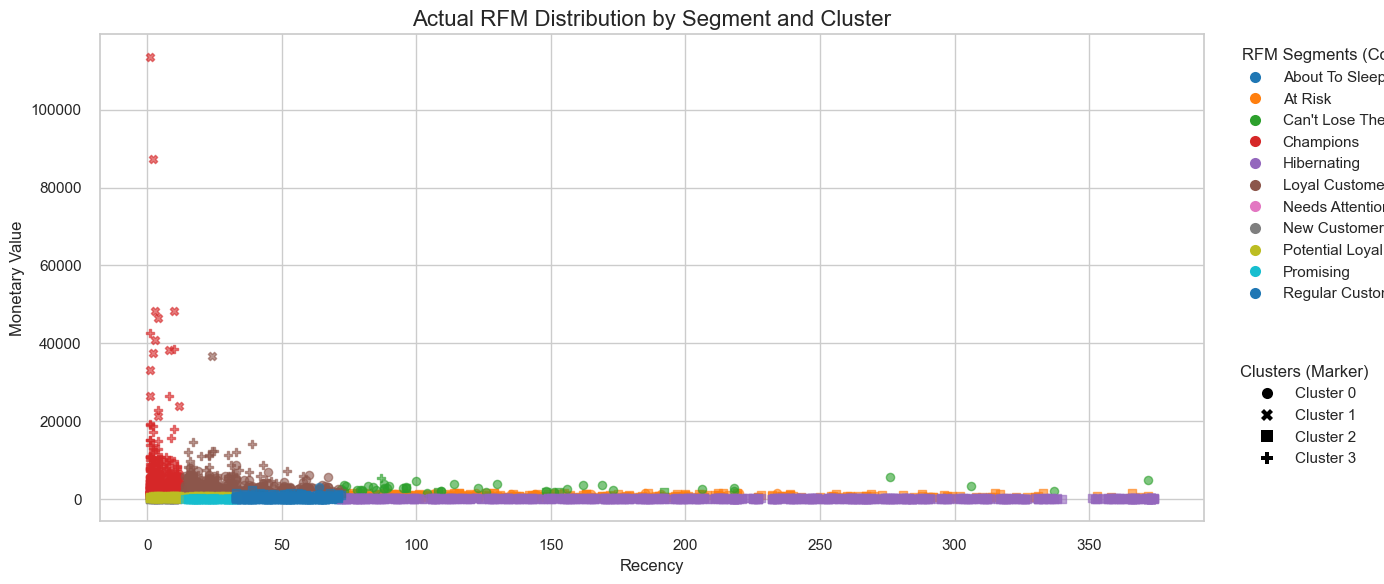

In [92]:
plt.figure(figsize=(14, 6))

segment_list = (
    final_customer_df['RFM_Segment']
    .dropna()
    .astype(str)
    .unique()
)
segment_list = sorted(segment_list)[:11]

cluster_list = sorted(final_customer_df['Cluster'].unique())

num_segments = len(segment_list)
palette = sns.color_palette("tab10", n_colors=num_segments)
markers = ['o', 'X', 's', 'P', 'D', '^', 'v', '<', '>']

for i, segment in enumerate(segment_list):
    df_segment = final_customer_df[
        final_customer_df['RFM_Segment'] == segment
    ]

    for cluster in cluster_list:
        df_point = df_segment[
            df_segment['Cluster'] == cluster
        ]

        plt.scatter(
            df_point['Recency'],
            df_point['Monetary'],
            color=palette[i],
            marker=markers[cluster % len(markers)],
            alpha=0.6,
            s=35
        )

plt.title("Actual RFM Distribution by Segment and Cluster", fontsize=16)
plt.xlabel("Recency")
plt.ylabel("Monetary Value")

segment_handles = [
    Line2D(
        [0], [0],
        marker='o',
        color=palette[i],
        linestyle='',
        markersize=8,
        label=segment
    )
    for i, segment in enumerate(segment_list)
]

legend_segment = plt.legend(
    handles=segment_handles,
    title="RFM Segments (Color)",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

plt.gca().add_artist(legend_segment)

cluster_handles = [
    Line2D(
        [0], [0],
        marker=markers[c % len(markers)],
        color='black',
        linestyle='',
        markersize=8,
        label=f"Cluster {c}"
    )
    for c in cluster_list
]

plt.legend(
    handles=cluster_handles,
    title="Clusters (Marker)",
    bbox_to_anchor=(1.02, 0.35),
    loc='upper left'
)

plt.tight_layout()
plt.show()

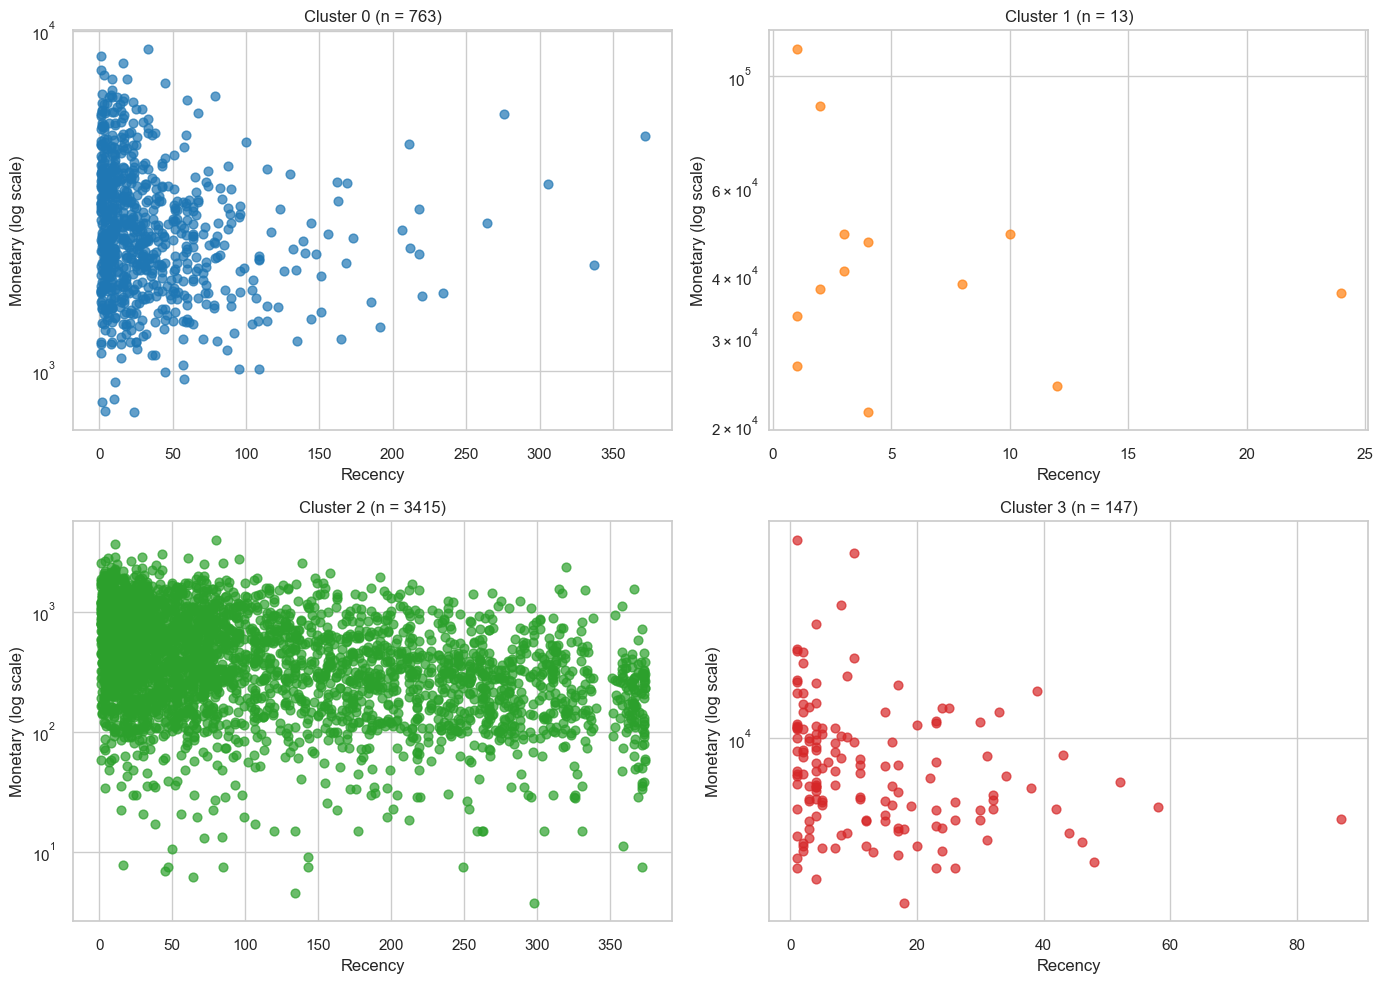

In [93]:
x_col = 'Recency'
y_col = 'Monetary'

clusters = sorted(final_customer_df['Cluster'].unique())
palette = sns.color_palette("tab10", n_colors=len(clusters))
cluster_colors = {
    cluster: palette[i]
    for i, cluster in enumerate(clusters)
}

n_clusters = len(clusters)
n_cols = 2
n_rows = int(np.ceil(n_clusters / n_cols))

plt.figure(figsize=(14, 5 * n_rows))

for idx, cluster in enumerate(clusters, start=1):
    plt.subplot(n_rows, n_cols, idx)

    df_cluster = final_customer_df[
        final_customer_df['Cluster'] == cluster
    ]

    plt.scatter(
        df_cluster[x_col],
        df_cluster[y_col],
        color=cluster_colors[cluster],
        alpha=0.7,
        s=40
    )

    plt.yscale("log")

    plt.title(
        f"Cluster {cluster} (n = {len(df_cluster)})",
        fontsize=12
    )
    plt.xlabel(x_col)
    plt.ylabel(
        f"{y_col} (log scale)"
        if y_col == "Monetary" else y_col
    )

plt.tight_layout()
plt.show()

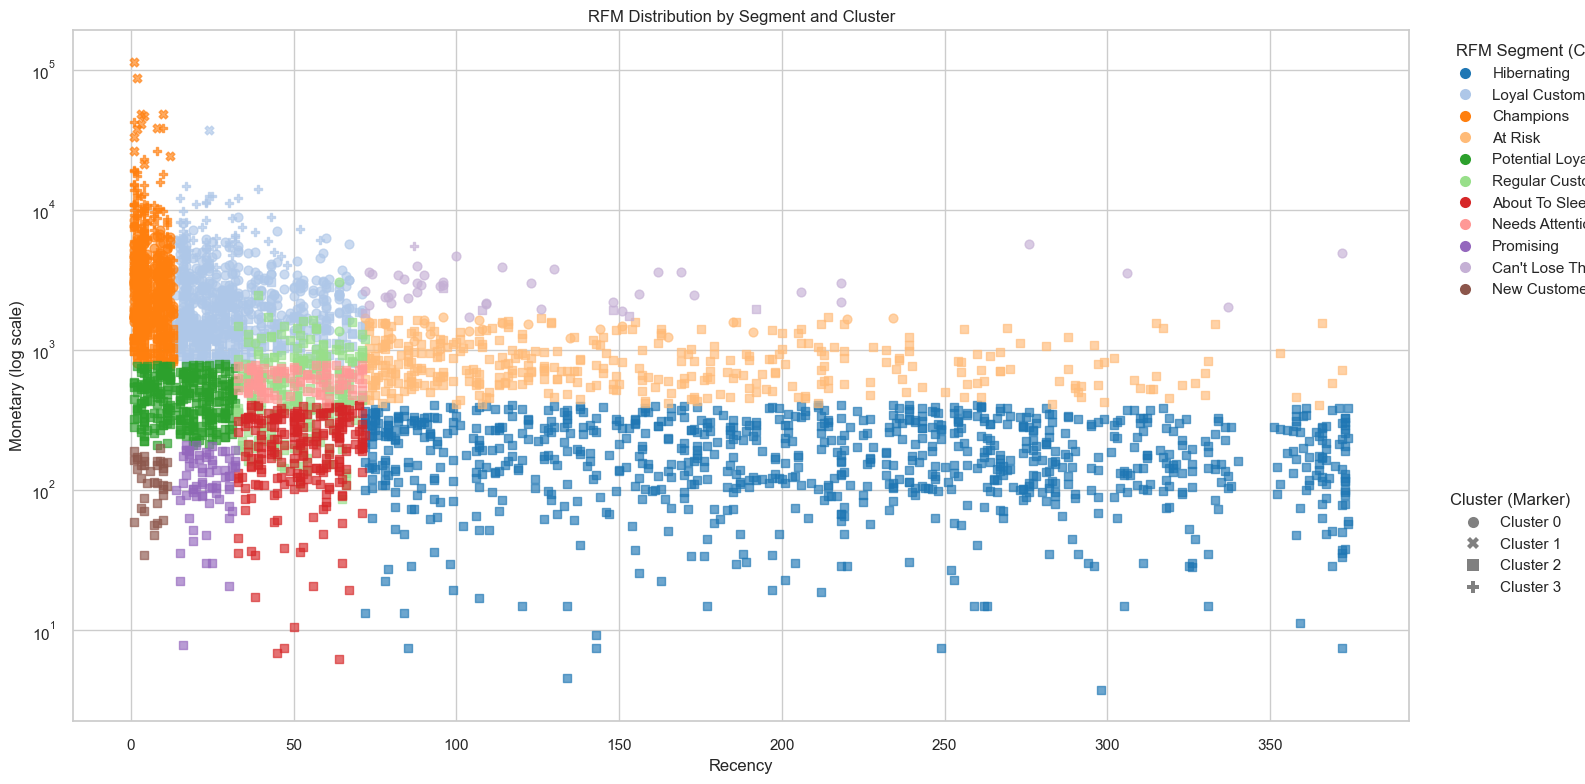

In [94]:
plt.figure(figsize=(16, 8))

segments = (
    final_customer_df['RFM_Segment']
    .dropna()
    .astype(str)
    .value_counts()
    .head(11)
    .index
    .tolist()
)

palette = sns.color_palette("tab20", n_colors=len(segments))
segment_color = {
    segment: palette[i]
    for i, segment in enumerate(segments)
}

clusters = sorted(
    final_customer_df['Cluster']
    .dropna()
    .unique()
)

cluster_markers = ['o', 'X', 's', 'P', 'D', '^', 'v']
cluster_marker_map = {
    cluster: cluster_markers[i % len(cluster_markers)]
    for i, cluster in enumerate(clusters)
}

for segment in segments:
    df_segment = final_customer_df[
        final_customer_df['RFM_Segment'] == segment
    ]

    for cluster in clusters:
        df_plot = df_segment[
            df_segment['Cluster'] == cluster
        ]

        plt.scatter(
            df_plot['Recency'],
            df_plot['Monetary'],
            color=segment_color[segment],
            marker=cluster_marker_map[cluster],
            s=40,
            alpha=0.65
        )

plt.yscale("log")
plt.xlabel("Recency")
plt.ylabel("Monetary (log scale)")
plt.title("RFM Distribution by Segment and Cluster")

segment_handles = [
    Line2D(
        [0], [0],
        marker='o',
        color=segment_color[segment],
        linestyle='',
        markersize=8,
        label=segment
    )
    for segment in segments
]

legend_segment = plt.legend(
    handles=segment_handles,
    title="RFM Segment (Color)",
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.gca().add_artist(legend_segment)

cluster_handles = [
    Line2D(
        [0], [0],
        marker=cluster_marker_map[cluster],
        color='grey',
        linestyle='',
        markersize=8,
        label=f"Cluster {cluster}"
    )
    for cluster in clusters
]

plt.legend(
    handles=cluster_handles,
    title="Cluster (Marker)",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.35)
)

plt.tight_layout()
plt.show()

## **Experimen 2: Algoritma K-Means & K=3**

In [95]:
from sklearn.cluster import MiniBatchKMeans

kmeans_2 = MiniBatchKMeans(
    n_clusters=3,
    batch_size=200,
    init="k-means++",
    n_init=55,
    max_iter=600,
    reassignment_ratio=0.0012,
    random_state=42
)

clusters_2 = kmeans_2.fit_predict(X)

In [96]:
clusters_2 = kmeans_2.fit_predict(X)

## **Evaluasi**

In [97]:
# silhouette_avg = silhouette_score(X, clusters_2)
# print("Silhouette Score:", silhouette_avg)

In [98]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
silhouette_avg_pca = silhouette_score(X_pca, clusters_2)
silhouette_avg_original = silhouette_score(X, clusters_2)

labels = kmeans_2.labels_

silhouette_avg = silhouette_score(X, labels)
calinski = calinski_harabasz_score(X, labels)

print("Clustering Metrics")
print(f"Silhouette Score (PCA) : {silhouette_avg_pca:.4f}")
print(f"Silhouette Score       : {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Score: {calinski:.4f}")


def silhouette_by_cluster(X_scaled, labels):
    sil_samples = silhouette_samples(X_scaled, labels)
    unique_clusters_2 = np.unique(labels)

    print("Silhouette Score per Cluster")
    for c in unique_clusters_2:
        cluster_score = sil_samples[labels == c].mean()
        print(f"Cluster {c}: {cluster_score:.4f}")


silhouette_by_cluster(X, labels)


Clustering Metrics
Silhouette Score (PCA) : 0.6120
Silhouette Score       : 0.6120
Calinski-Harabasz Score: 1381.1863
Silhouette Score per Cluster
Cluster 0: 0.2804
Cluster 1: 0.8223
Cluster 2: 0.0051


## **Interpretasi**

In [99]:
cluster_result_2 = pd.DataFrame({
    'CustomerID': X_final_full.index,
    'Cluster_2': clusters_2
})

cluster_result.head()


CustomerID  Cluster
0    12346.00        2
1    12347.00        0
2    12348.00        2
3    12349.00        2
4    12350.00        2

In [100]:
final_df_2 = pd.concat([cluster_result_2.set_index('CustomerID'),
                      X_final_full], axis=1)

final_df_2.head()


Cluster_2  Recency_scaled  Frequency_scaled  Monetary_scaled  \
CustomerID                                                                 
12346.00            1            1.62             -2.43            -2.46   
12347.00            0           -1.82              1.19             1.49   
12348.00            0            0.30             -0.21            -0.04   
12349.00            0           -0.69              0.46             0.65   
12350.00            1            1.57             -0.67            -0.54   

            Quantity_total  UnitPrice_avg  
CustomerID                                 
12346.00             27.00           1.04  
12347.00           2167.00           2.50  
12348.00            716.00           1.57  
12349.00            613.00           3.44  
12350.00            197.00           1.93

In [101]:
cluster_profile = final_df_2.groupby('Cluster_2').mean().round(2)
cluster_profile


Recency_scaled  Frequency_scaled  Monetary_scaled  Quantity_total  \
Cluster_2                                                                      
0                   -0.48              0.78             0.84         1121.82   
1                    0.33             -0.52            -0.57          205.47   
2                   -1.17              1.78             1.98         5316.83   

           UnitPrice_avg  
Cluster_2                 
0                   2.54  
1                   2.93  
2                   2.46

In [102]:
cols = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']

X_original_part = scaler.inverse_transform(final_df_2[cols])
final_df_2[['Recency','Frequency','Monetary']] = X_original_part


In [103]:
cluster_profile_2 = final_df_2.groupby('Cluster_2').mean().round(2)
cluster_profile_2


Recency_scaled  Frequency_scaled  Monetary_scaled  Quantity_total  \
Cluster_2                                                                      
0                   -0.48              0.78             0.84         1121.82   
1                    0.33             -0.52            -0.57          205.47   
2                   -1.17              1.78             1.98         5316.83   

           UnitPrice_avg  Recency  Frequency  Monetary  
Cluster_2                                               
0                   2.54    -0.48       0.78      0.84  
1                   2.93     0.33      -0.52     -0.57  
2                   2.46    -1.17       1.78      1.98

In [104]:
rfm_clean = rfm[['Recency', 'Frequency', 'Monetary',
                 'R_Score', 'F_Score', 'M_Score']]

# jika final_df_2 sudah punya Recency/Frequency/Monetary, hapus dulu
rfm_clean = rfm_clean.drop(columns=['Frequency', 'Recency', 'Monetary'], errors='ignore')

final_merged_2 = final_df_2.join(rfm_clean, how='left')


In [105]:
scores = ['R_Score', 'F_Score', 'M_Score']

cluster_score_counts = (
    final_merged_2
    .groupby('Cluster_2')[scores]
    .apply(lambda df: df.apply(lambda col: col.value_counts().reindex([1,2,3,4,5], fill_value=0)))
)

cluster_score_counts


R_Score  F_Score  M_Score
Cluster_2                             
0         1       44        0        0
          2      224       19        6
          3      285      198       98
          4      366      572      597
          5      416      546      634
1         1      823      868      868
          2      641      848      861
          3      566      670      770
          4      440      293      269
          5      302       93        4
2         1        1        0        0
          2        2        0        0
          3       17        0        0
          4       61        2        1
          5      150      229      230

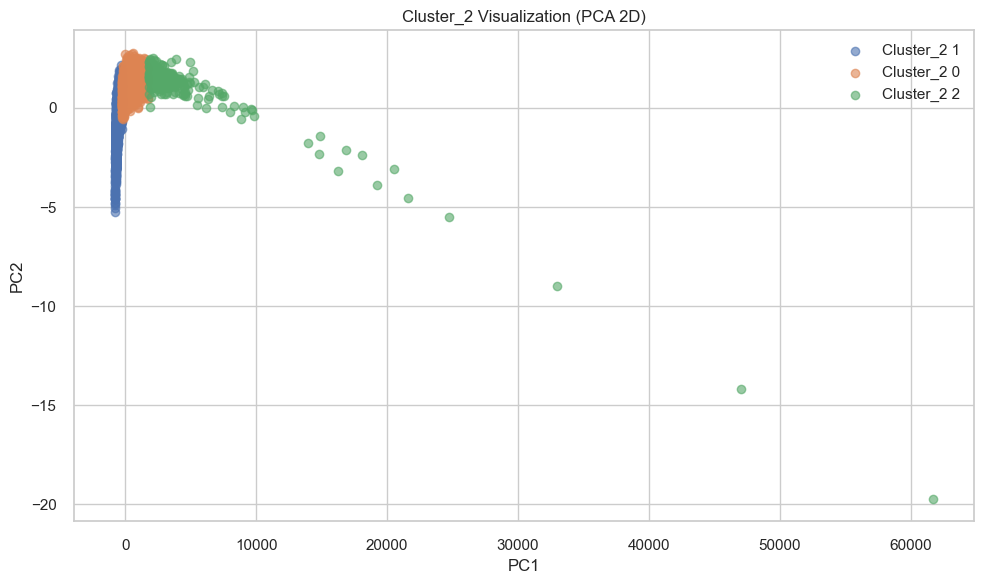

In [106]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_final_full)

final_df_2['PC1'] = pca_result[:,0]
final_df_2['PC2'] = pca_result[:,1]

plt.figure(figsize=(10,6))
for c in final_df_2['Cluster_2'].unique():
    plt.scatter(
        final_df_2[final_df_2['Cluster_2']==c]['PC1'],
        final_df_2[final_df_2['Cluster_2']==c]['PC2'],
        label=f'Cluster_2 {c}', alpha=0.6
    )

plt.legend()
plt.title("Cluster_2 Visualization (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


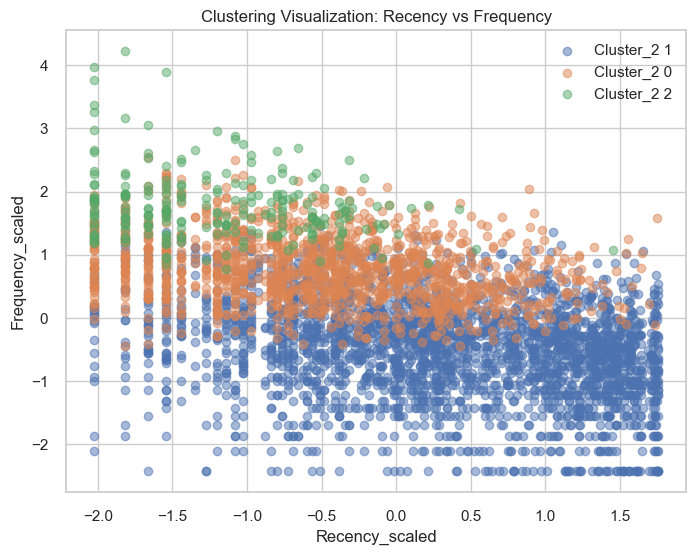

In [107]:
plt.figure(figsize=(8,6))
for c in final_df_2['Cluster_2'].unique():
    subset = final_df_2[final_df_2['Cluster_2']==c]
    plt.scatter(subset['Recency_scaled'], subset['Frequency_scaled'], alpha=0.5, label=f'Cluster_2 {c}')

plt.xlabel('Recency_scaled')
plt.ylabel('Frequency_scaled')
plt.title('Clustering Visualization: Recency vs Frequency')
plt.legend()
plt.show()


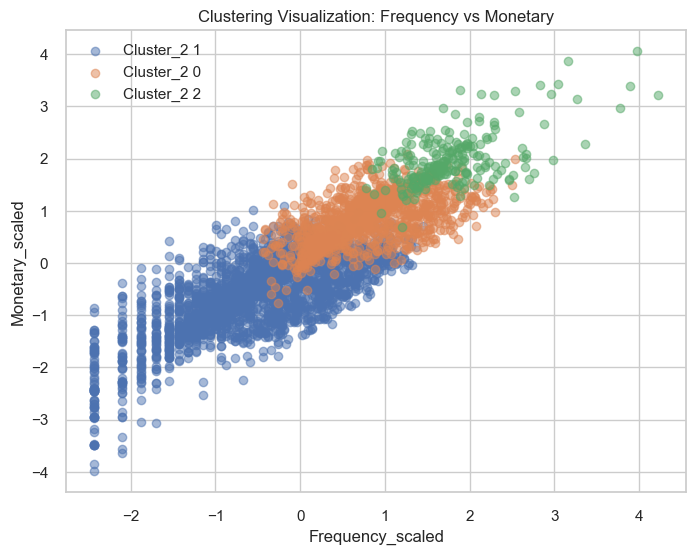

In [108]:
plt.figure(figsize=(8,6))
for c in final_df_2['Cluster_2'].unique():
    subset = final_df_2[final_df_2['Cluster_2']==c]
    plt.scatter(subset['Frequency_scaled'], subset['Monetary_scaled'], alpha=0.5, label=f'Cluster_2 {c}')

plt.xlabel('Frequency_scaled')
plt.ylabel('Monetary_scaled')
plt.title('Clustering Visualization: Frequency vs Monetary')
plt.legend()
plt.show()


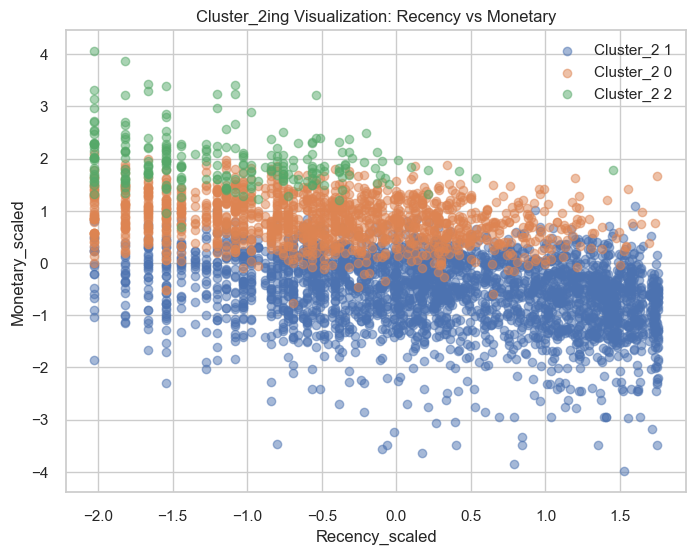

In [109]:
plt.figure(figsize=(8,6))
for c in final_df_2['Cluster_2'].unique():
    subset = final_df_2[final_df_2['Cluster_2']==c]
    plt.scatter(subset['Recency_scaled'], subset['Monetary_scaled'], alpha=0.5, label=f'Cluster_2 {c}')

plt.xlabel('Recency_scaled')
plt.ylabel('Monetary_scaled')
plt.title('Cluster_2ing Visualization: Recency vs Monetary')
plt.legend()
plt.show()


In [110]:
rfm_profile = final_df_2.groupby('Cluster_2')[[
    'Recency_scaled',
    'Frequency_scaled',
    'Monetary_scaled'
]].mean().round(2)

rfm_profile


Recency_scaled  Frequency_scaled  Monetary_scaled
Cluster_2                                                   
0                   -0.48              0.78             0.84
1                    0.33             -0.52            -0.57
2                   -1.17              1.78             1.98

In [111]:
final_customer_df_2 = df_customer.merge(cluster_result_2, on='CustomerID', how='left')

final_customer_df_2.head()

CustomerID  Quantity_total  UnitPrice_avg  TotalAmount_total  \
0    12346.00           27.00           1.04              28.08   
1    12347.00         2167.00           2.50            3877.44   
2    12348.00          716.00           1.57             557.57   
3    12349.00          613.00           3.44            1336.65   
4    12350.00          197.00           1.93             301.90   

   Total_transaction_total  InvoiceYearMonth_num  Recency  Frequency  \
0                    28.08                201101      326          1   
1                  3877.44                201112        2        182   
2                   557.57                201109       75         31   
3                  1336.65                201111       19         73   
4                   301.90                201102      310         17   

   Monetary  R_Score  F_Score  M_Score  RFM_Score      RFM_Segment  Cluster_2  
0     28.08        1        1        1          3      Hibernating          1  
1   3877.44        5        5        5         15        Champions          0  
2    557.57        2        3        3          8          At Risk          0  
3   1336.65        4        4        4         12  Loyal Customers          0  
4    301.90        1        2        2          5      Hibernating          1

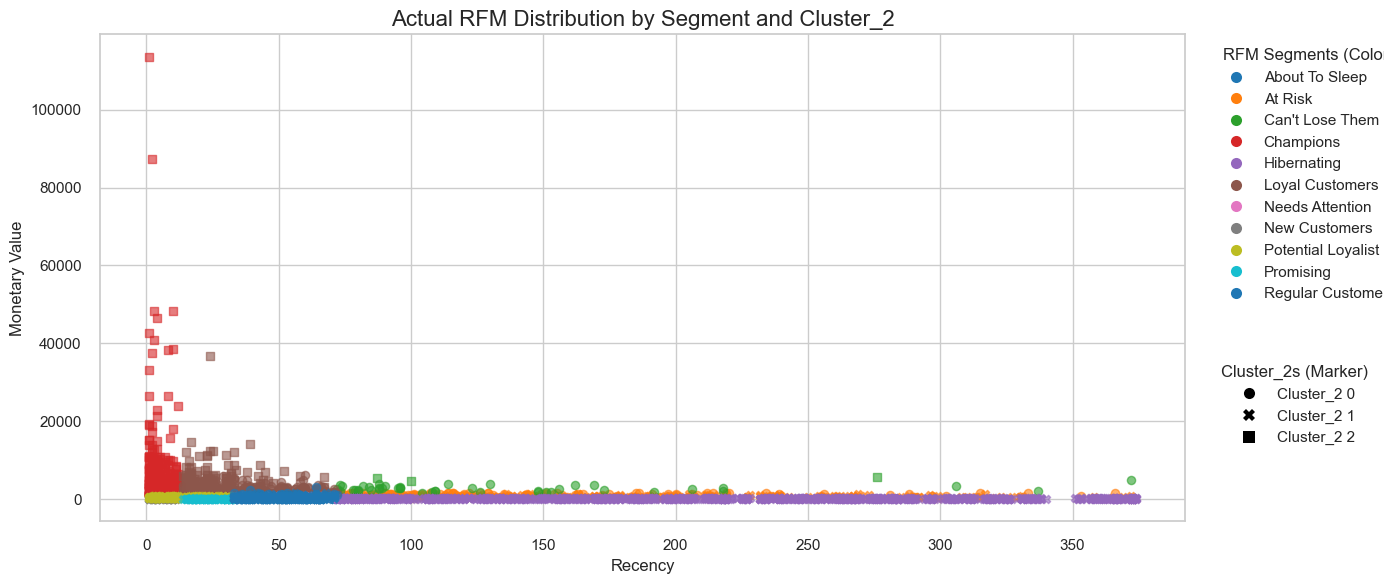

In [112]:
plt.figure(figsize=(14, 6))

segment_list = (
    final_customer_df_2['RFM_Segment']
    .dropna()
    .astype(str)
    .unique()
)

segment_list = sorted(segment_list)[:11]

cluster_2_list = sorted(final_customer_df_2['Cluster_2'].unique())

num_segments = 11

palette = sns.color_palette("tab10", n_colors=num_segments)
markers = ['o', 'X', 's', 'P', 'D', '^', 'v', '<', '>']

for i, segment in enumerate(segment_list):
    df_seg = final_customer_df_2[final_customer_df_2['RFM_Segment'] == segment]

    for clust in cluster_2_list:
        df_point = df_seg[df_seg['Cluster_2'] == clust]

        plt.scatter(
            df_point['Recency'],
            df_point['Monetary'],
            color=palette[i],
            marker=markers[clust % len(markers)],
            alpha=0.6,
            s=35
        )

plt.title("Actual RFM Distribution by Segment and Cluster_2", fontsize=16)
plt.xlabel("Recency")
plt.ylabel("Monetary Value")

segment_handles = [
    Line2D(
        [0], [0],
        marker='o',
        color=palette[i],
        linestyle='',
        markersize=8,
        label=segment
    )
    for i, segment in enumerate(segment_list)
]

legend1 = plt.legend(
    handles=segment_handles,
    title="RFM Segments (Color)",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.gca().add_artist(legend1)

cluster_2_handles = [
    Line2D(
        [0], [0],
        marker=markers[c % len(markers)],
        color='black',
        linestyle='',
        markersize=8,
        label=f"Cluster_2 {c}"
    )
    for c in cluster_2_list
]

plt.legend(
    handles=cluster_2_handles,
    title="Cluster_2s (Marker)",
    bbox_to_anchor=(1.02, 0.35),
    loc='upper left'
)

plt.tight_layout()
plt.show()


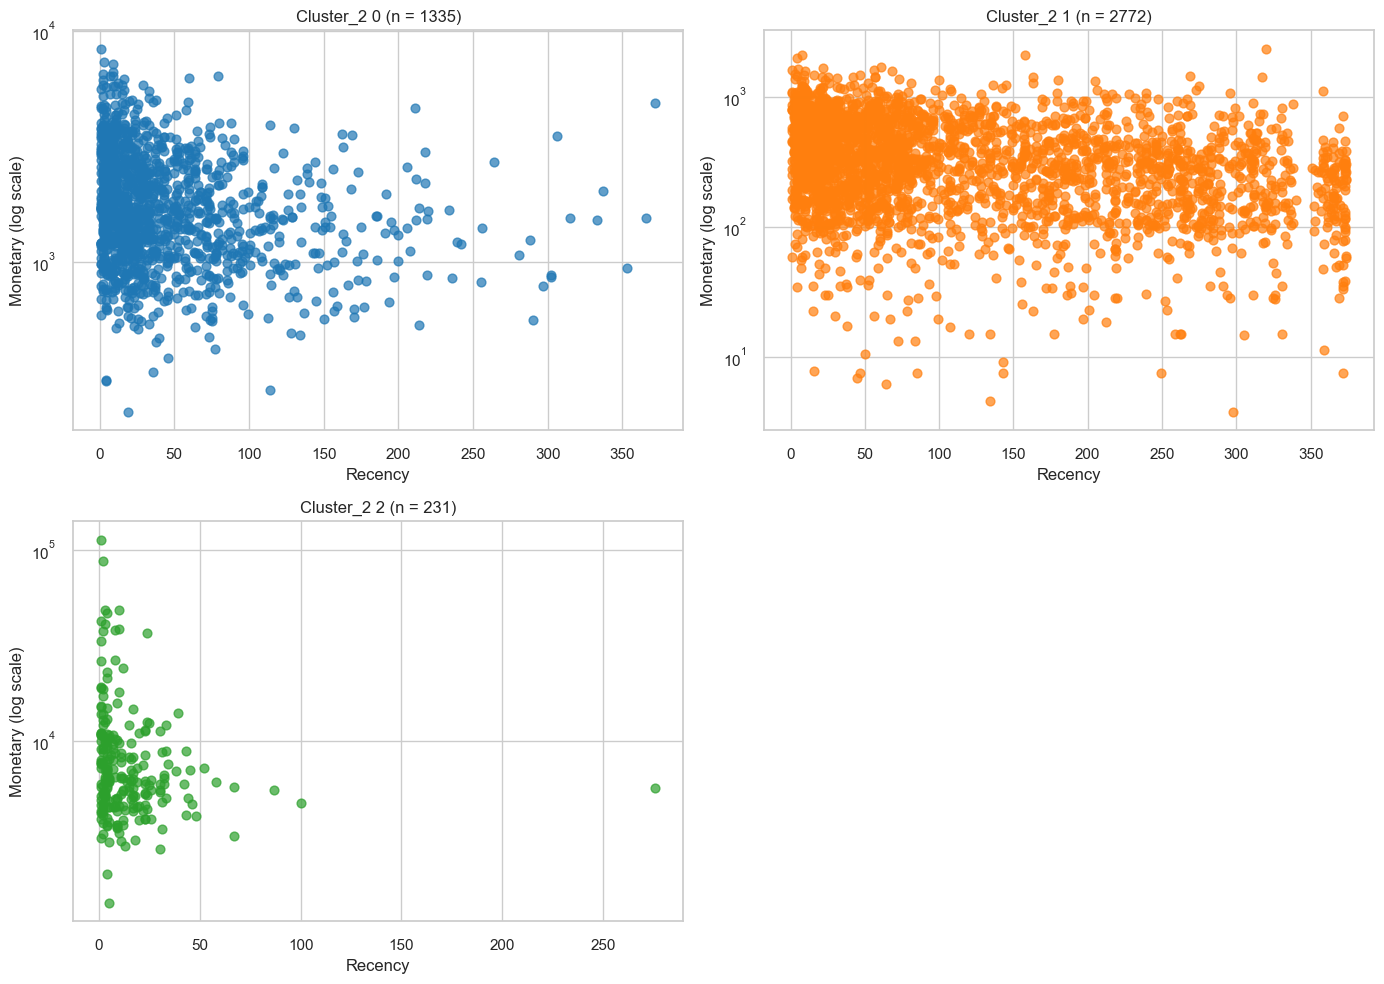

In [113]:
x_col = 'Recency'
y_col = 'Monetary'

cluster_2s = sorted(final_customer_df_2['Cluster_2'].unique())

palette = sns.color_palette("tab10", n_colors=len(cluster_2s))
cluster_2_colors = {c: palette[i] for i, c in enumerate(cluster_2s)}

n_cluster_2s = len(cluster_2s)
n_cols = 2
n_rows = int(np.ceil(n_cluster_2s / n_cols))

plt.figure(figsize=(14, 5 * n_rows))

for idx, c in enumerate(cluster_2s, 1):
    plt.subplot(n_rows, n_cols, idx)

    df_c = final_customer_df_2[final_customer_df_2['Cluster_2'] == c]

    plt.scatter(
        df_c[x_col],
        df_c[y_col],
        color=cluster_2_colors[c],
        alpha=0.7,
        s=40
    )

    plt.yscale("log")
    plt.title(f"Cluster_2 {c} (n = {len(df_c)})", fontsize=12)
    plt.xlabel(x_col)
    plt.ylabel(f"{y_col} (log scale)" if y_col == "Monetary" else y_col)

plt.tight_layout()
plt.show()

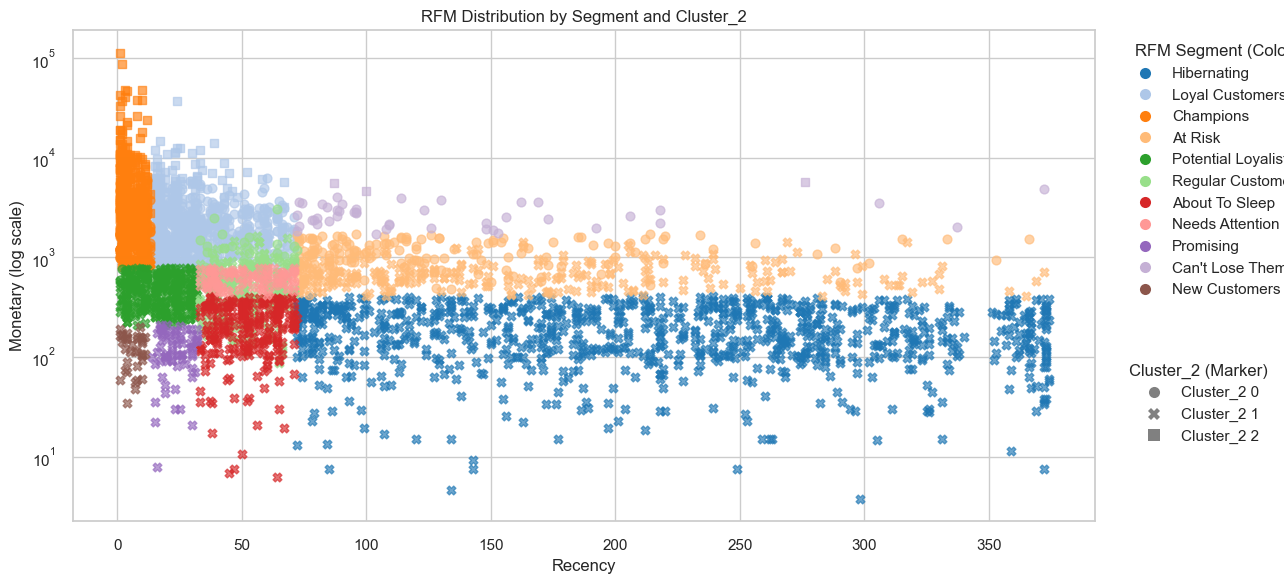

In [114]:
plt.figure(figsize=(13, 6))

segments = (
    final_customer_df_2['RFM_Segment']
    .dropna()
    .astype(str)
    .value_counts()
    .head(11)
    .index
    .tolist()
)

palette = sns.color_palette("tab20", n_colors=11)
segment_color = dict(zip(segments, palette))

cluster_2s = sorted(final_customer_df_2['Cluster_2'].dropna().unique())
cluster_2_markers = ['o', 'X', 's', 'P', 'D', '^', 'v']
cluster_2_marker_map = {c: cluster_2_markers[c % len(cluster_2_markers)] for c in cluster_2s}

for seg in segments:
    df_seg = final_customer_df_2[final_customer_df_2['RFM_Segment'] == seg]

    for c in cluster_2s:
        df_plot = df_seg[df_seg['Cluster_2'] == c]

        plt.scatter(
            df_plot['Recency'],
            df_plot['Monetary'],
            color=segment_color[seg],
            marker=cluster_2_marker_map[c],
            s=40,
            alpha=0.65
        )

plt.yscale("log")
plt.xlabel("Recency")
plt.ylabel("Monetary (log scale)")
plt.title("RFM Distribution by Segment and Cluster_2")

seg_handles = [
    Line2D(
        [0], [0],
        marker='o',
        color=segment_color[seg],
        linestyle='',
        markersize=8,
        label=seg
    )
    for seg in segments
]

legend1 = plt.legend(
    handles=seg_handles,
    title="RFM Segment (Color)",
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(legend1)

clus_handles = [
    Line2D(
        [0], [0],
        marker=cluster_2_marker_map[c],
        color='grey',
        linestyle='',
        markersize=8,
        label=f"Cluster_2 {c}"
    )
    for c in cluster_2s
]

plt.legend(
    handles=clus_handles,
    title="Cluster_2 (Marker)",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.35)
)

plt.tight_layout()
plt.show()


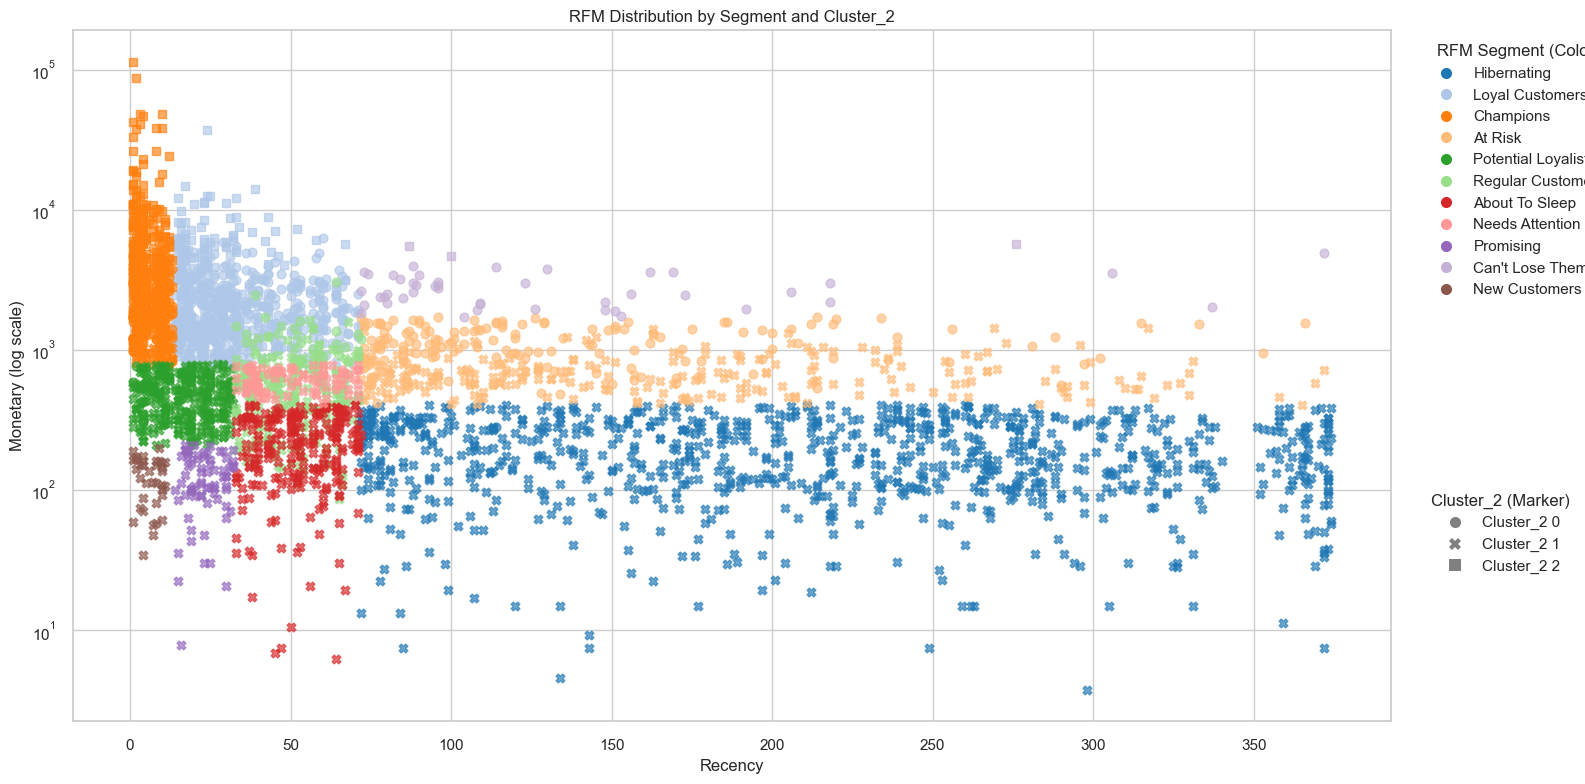

In [115]:
plt.figure(figsize=(16, 8))

segments = (
    final_customer_df_2['RFM_Segment']
    .dropna()
    .astype(str)
    .value_counts()
    .head(11)
    .index
    .tolist()
)

palette = sns.color_palette("tab20", n_colors=len(segments))
segment_color = {
    segment: palette[i]
    for i, segment in enumerate(segments)
}

cluster_2s = sorted(
    final_customer_df_2['Cluster_2']
    .dropna()
    .unique()
)

cluster_2_markers = ['o', 'X', 's', 'P', 'D', '^', 'v']
cluster_2_marker_map = {
    cluster_2: cluster_2_markers[i % len(cluster_2_markers)]
    for i, cluster_2 in enumerate(cluster_2s)
}

for segment in segments:
    df_segment = final_customer_df_2[
        final_customer_df_2['RFM_Segment'] == segment
    ]

    for cluster_2 in cluster_2s:
        df_plot = df_segment[
            df_segment['Cluster_2'] == cluster_2
        ]

        plt.scatter(
            df_plot['Recency'],
            df_plot['Monetary'],
            color=segment_color[segment],
            marker=cluster_2_marker_map[cluster_2],
            s=40,
            alpha=0.65
        )

plt.yscale("log")
plt.xlabel("Recency")
plt.ylabel("Monetary (log scale)")
plt.title("RFM Distribution by Segment and Cluster_2")

segment_handles = [
    Line2D(
        [0], [0],
        marker='o',
        color=segment_color[segment],
        linestyle='',
        markersize=8,
        label=segment
    )
    for segment in segments
]

legend_segment = plt.legend(
    handles=segment_handles,
    title="RFM Segment (Color)",
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.gca().add_artist(legend_segment)

cluster_2_handles = [
    Line2D(
        [0], [0],
        marker=cluster_2_marker_map[cluster_2],
        color='grey',
        linestyle='',
        markersize=8,
        label=f"Cluster_2 {cluster_2}"
    )
    for cluster_2 in cluster_2s
]

plt.legend(
    handles=cluster_2_handles,
    title="Cluster_2 (Marker)",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.35)
)

plt.tight_layout()
plt.show()

## **MENYIMPAN HASIL CLUSTERING**

In [116]:
final_customer_df.to_csv('customer_segmentation.csv', index=False)

In [117]:
os.makedirs("models", exist_ok=True)

clustering_bundle = {
    "power_transformer": pt,
    "scaler": scaler,
    "model": kmeans,
    "model_type": "MiniBatchKMeans",
    "n_clusters": best_k,
    "features": list(rfm_features.columns),
    "pipeline_order": [
        "PowerTransformer (Yeo-Johnson)",
        "StandardScaler",
        "MiniBatchKMeans"
    ],
    "model_params": kmeans.get_params(),
    "created_at": datetime.now().isoformat()
}

joblib.dump(
    clustering_bundle,
    "models/clustering_bundle.pkl"
)

print("Model clustering berhasil disimpan ke folder 'models/'")


Model clustering berhasil disimpan ke folder 'models/'


## **LOAD MODEL**

In [118]:
# import joblib
# import streamlit as st

# @st.cache_resource
# def load_clustering_model():
#     bundle = joblib.load("models/clustering_bundle.pkl")
#     return bundle

# bundle = load_clustering_model()

# pt = bundle["power_transformer"]
# scaler = bundle["scaler"]
# kmeans = bundle["model"]
# feature_cols = bundle["features"]


In [119]:
# X_new = new_data[feature_cols]

# X_power = pt.transform(X_new)
# X_scaled = scaler.transform(X_power)

# cluster_pred = kmeans.predict(X_scaled)
